In [1]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
from scipy.stats import chi2_contingency, f_oneway

import datetime
import calendar
import math

cmap = cm.get_cmap('gnuplot')
pd.set_option('display.max_columns', None)


# Data Source

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

# Exploratory Data Analysis

In [3]:
f_data = dataset[dataset["class"] == 1]
f_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,Direct,IE,F,35,1.120619e+09,1
25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1
29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,SEO,Chrome,F,27,2.836025e+09,1
59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,SEO,IE,M,30,2.740590e+09,1
...,...,...,...,...,...,...,...,...,...,...,...
151082,305464,2015-01-07 09:06:55,2015-01-07 09:06:56,90,TVYSUZLTILQQN,SEO,IE,M,34,3.067794e+09,1
151099,115473,2015-01-01 07:26:14,2015-01-01 07:26:15,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,1
151103,5557,2015-01-04 23:03:04,2015-01-04 23:03:05,27,AWFGZTEHXMWEJ,Direct,Chrome,M,39,3.306999e+09,1
151104,252360,2015-01-04 09:40:44,2015-01-04 09:40:45,20,GSEYHMCBONPHK,Ads,IE,F,39,2.698870e+09,1


## Browser

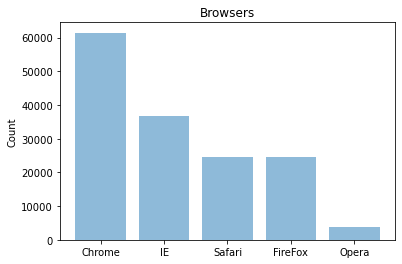

In [4]:
browsers = pd.DataFrame(dataset.browser.value_counts()).reset_index()
browsers.columns = ["Browser","Count"]
plt.bar(browsers.Browser, browsers.Count, align='center', alpha=0.5)
plt.ylabel('Count')
plt.title('Browsers')

plt.show()

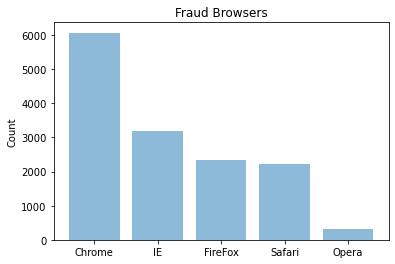

In [5]:
browsers = pd.DataFrame(f_data.browser.value_counts()).reset_index()
browsers.columns = ["Browser","Count"]
plt.bar(browsers.Browser, browsers.Count, align='center', alpha=0.5)
plt.ylabel('Count')
plt.title('Fraud Browsers')

plt.show()

## Benford's law for purchase_value

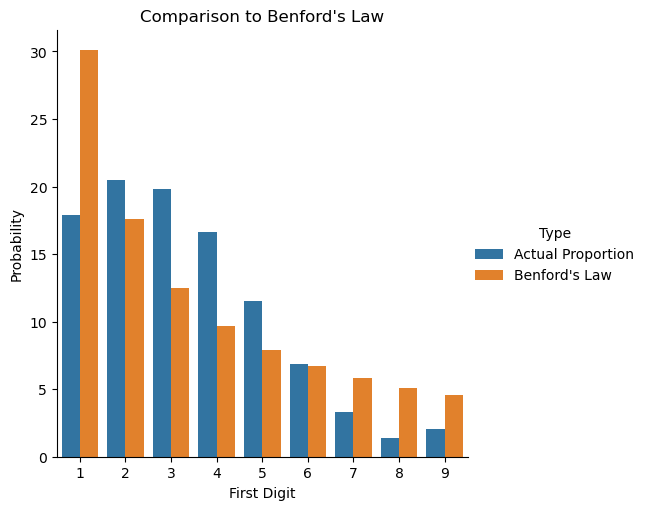

In [6]:
df_benford = dataset.copy()

df_benford['purchase_value'] = df_benford["purchase_value"].astype(str)
df_benford['first_digit'] = df_benford['purchase_value'].str.slice(0,1)

# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])
temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)
temp = temp.drop(columns = ["level_0"])
temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")

plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

## Benford's law for userid

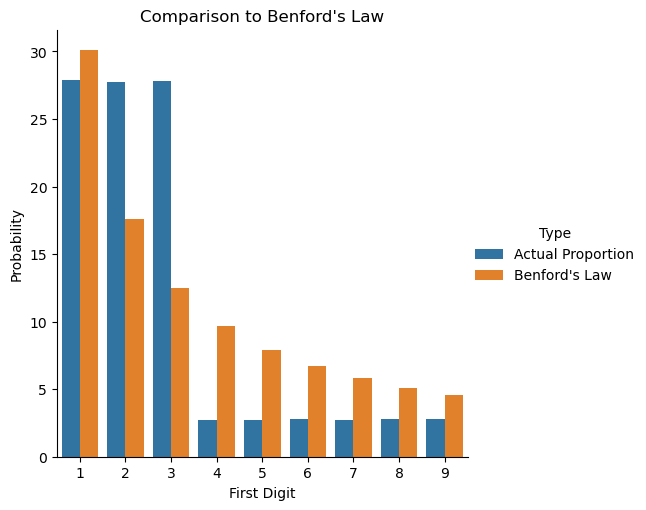

In [7]:
df_benford = dataset.copy()

df_benford['user_id'] = df_benford["user_id"].astype(str)
df_benford['first_digit'] = df_benford['user_id'].str.slice(0,1)

# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])
temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)
temp = temp.drop(columns = ["level_0"])
temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")

plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

## Boxplot for purchase value

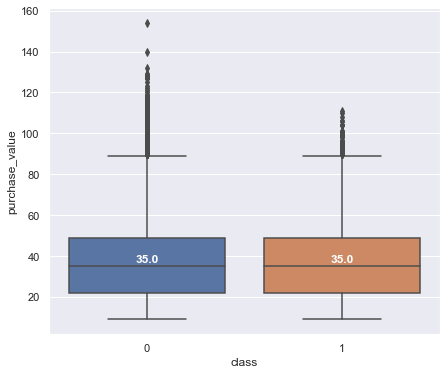

In [8]:
sns.set(rc={'figure.figsize':(7,6)})
box_plot = sns.boxplot(data=dataset , y='purchase_value', x='class')
medians = dataset.groupby(['class'])['purchase_value'].median()
vertical_offset = dataset['purchase_value'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')

## Feature Engineering
### Making new features 

In [9]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [10]:
import calendar
dataset['signup_time'] =  pd.to_datetime(dataset['signup_time'], format='%Y-%m-%d %H:%M:%S')
dataset['purchase_time'] =  pd.to_datetime(dataset['purchase_time'], format='%Y-%m-%d %H:%M:%S')
# get diff in days, time, seconds, fast_purchase from purchase_time and signup_time
dataset['diff_dt'] = dataset['signup_time'] - dataset['purchase_time']
dataset['days'] = dataset['diff_dt'].dt.days
dataset['time'] = dataset['diff_dt'].astype(str).apply(lambda x : x[-8:])
#dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time
dataset['seconds_after_signup'] = dataset['diff_dt'].dt.total_seconds()
dataset['fast_purchase'] = dataset['seconds_after_signup'].apply(lambda x: '1' if x < 30 else '0')

# get month, week, hour of the day from purchase_time
dataset['month_purchase'] = pd.to_datetime(dataset['purchase_time']).dt.strftime('%B')
dataset['weekday_purchase'] = pd.to_datetime(dataset['purchase_time']).dt.strftime('%A')
dataset['hour_of_the_day'] = pd.to_datetime(dataset['purchase_time']).dt.strftime('%H').astype(int)

# categorise hour of the day
dataset["time_of_day"] = dataset['hour_of_the_day'].apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early afternoon" if x < 16 else
                                                             "afternoon" if x < 20 else
                                                             "evening"
                                                            )

# get country risk from mean of class
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))
risk_country["risk_country"] = risk_country["class"].apply(lambda x:"High Risk" if x > 0.25 else "Medium Risk" if x > 0.10 else "Low Risk")
dataset = dataset.merge(risk_country.drop("class",axis=1),left_on='IP_country', right_on = 'IP_country')

# get count of duplicated devices
device_duplicates = dataset.groupby('device_id')['device_id'].count().rename('freq_device').reset_index()
dataset = dataset.merge(device_duplicates, on='device_id')
dataset['freq_device'] = dataset['freq_device'].apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# get count of countries by device_id
country_count = dataset.groupby(["device_id", "IP_country"])['IP_country'].count().rename('country_count').reset_index()
dataset = dataset.merge(country_count, on=["device_id", 'IP_country'], how='left')

# get count of same purchase by device_id
duplicate = dataset.groupby(['device_id', 'purchase_value'])['purchase_value'].count().rename('freq_same_purchase').reset_index()
dataset = dataset.merge(duplicate, on=['device_id', 'purchase_value'], how='left')
dataset["freq_same_purchase"] = dataset['freq_same_purchase'].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )

# categorise age
dataset["age_category"] = dataset['age'].apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

dataset = dataset.drop(columns=['diff_dt', 'days', 'time'])

In [11]:
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

In [12]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'IP_country', 'seconds_after_signup', 'fast_purchase', 'month_purchase',
       'weekday_purchase', 'hour_of_the_day', 'time_of_day', 'risk_country',
       'freq_device', 'country_count', 'freq_same_purchase', 'age_category',
       'countries_from_device'],
      dtype='object')

## Data Visualisation for the new features

In [13]:
f_data = dataset[dataset["class"] == 1]
non_f_data = dataset[dataset["class"] == 0]

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2362680609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['month_purchase'] = pd.Categorical(f_data['month_purchase'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2362680609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['weekday_purchase'] = pd.Categoric

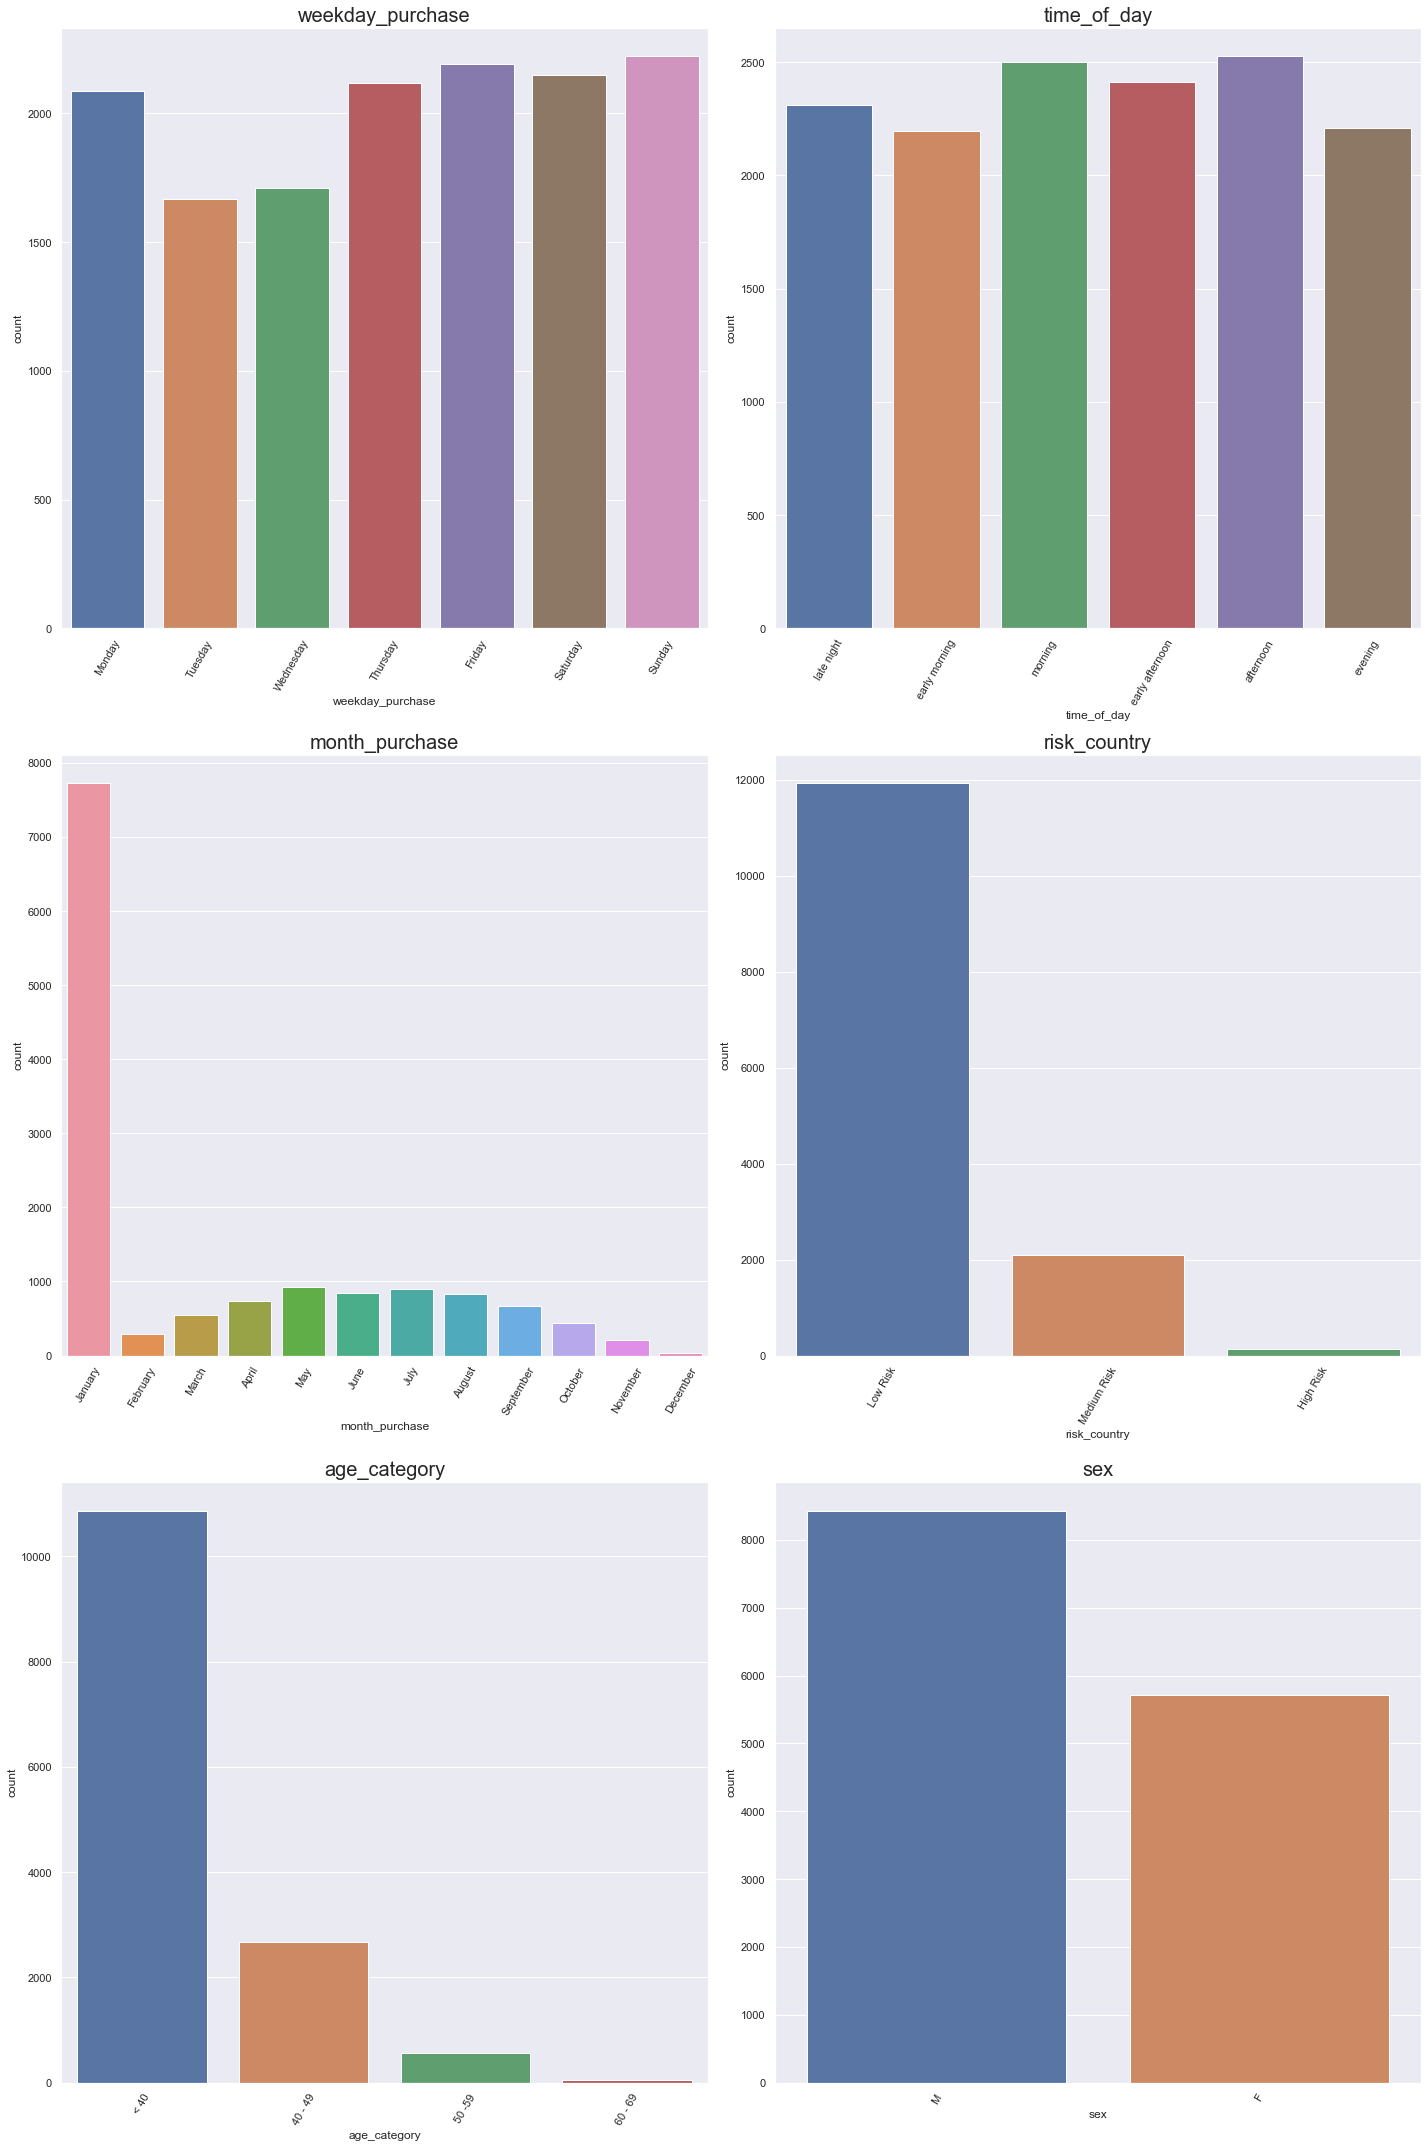

In [14]:
cat_variables = ['month_purchase', 'weekday_purchase', 'time_of_day']
f_data['month_purchase'] = pd.Categorical(f_data['month_purchase'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
f_data['weekday_purchase'] = pd.Categorical(f_data['weekday_purchase'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
f_data['time_of_day'] = pd.Categorical(f_data['time_of_day'], categories=['late night', 'early morning', 'morning', 'early afternoon', 'afternoon', 'evening'], ordered=True)

non_f_data['month_purchase'] = pd.Categorical(non_f_data['month_purchase'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
non_f_data['weekday_purchase'] = pd.Categorical(non_f_data['weekday_purchase'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
non_f_data['time_of_day'] = pd.Categorical(non_f_data['time_of_day'], categories=['late night', 'early morning', 'morning', 'early afternoon', 'afternoon', 'evening'], ordered=True)

cat_variables = ['weekday_purchase','time_of_day', 'month_purchase', 'risk_country', 'age_category', 'sex']

# Set up the matplotlib figure for fraud data 
f, axes = plt.subplots(3, 2, figsize=(20, 30), sharex=False)

# sns.despine(left=True)
for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=f_data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

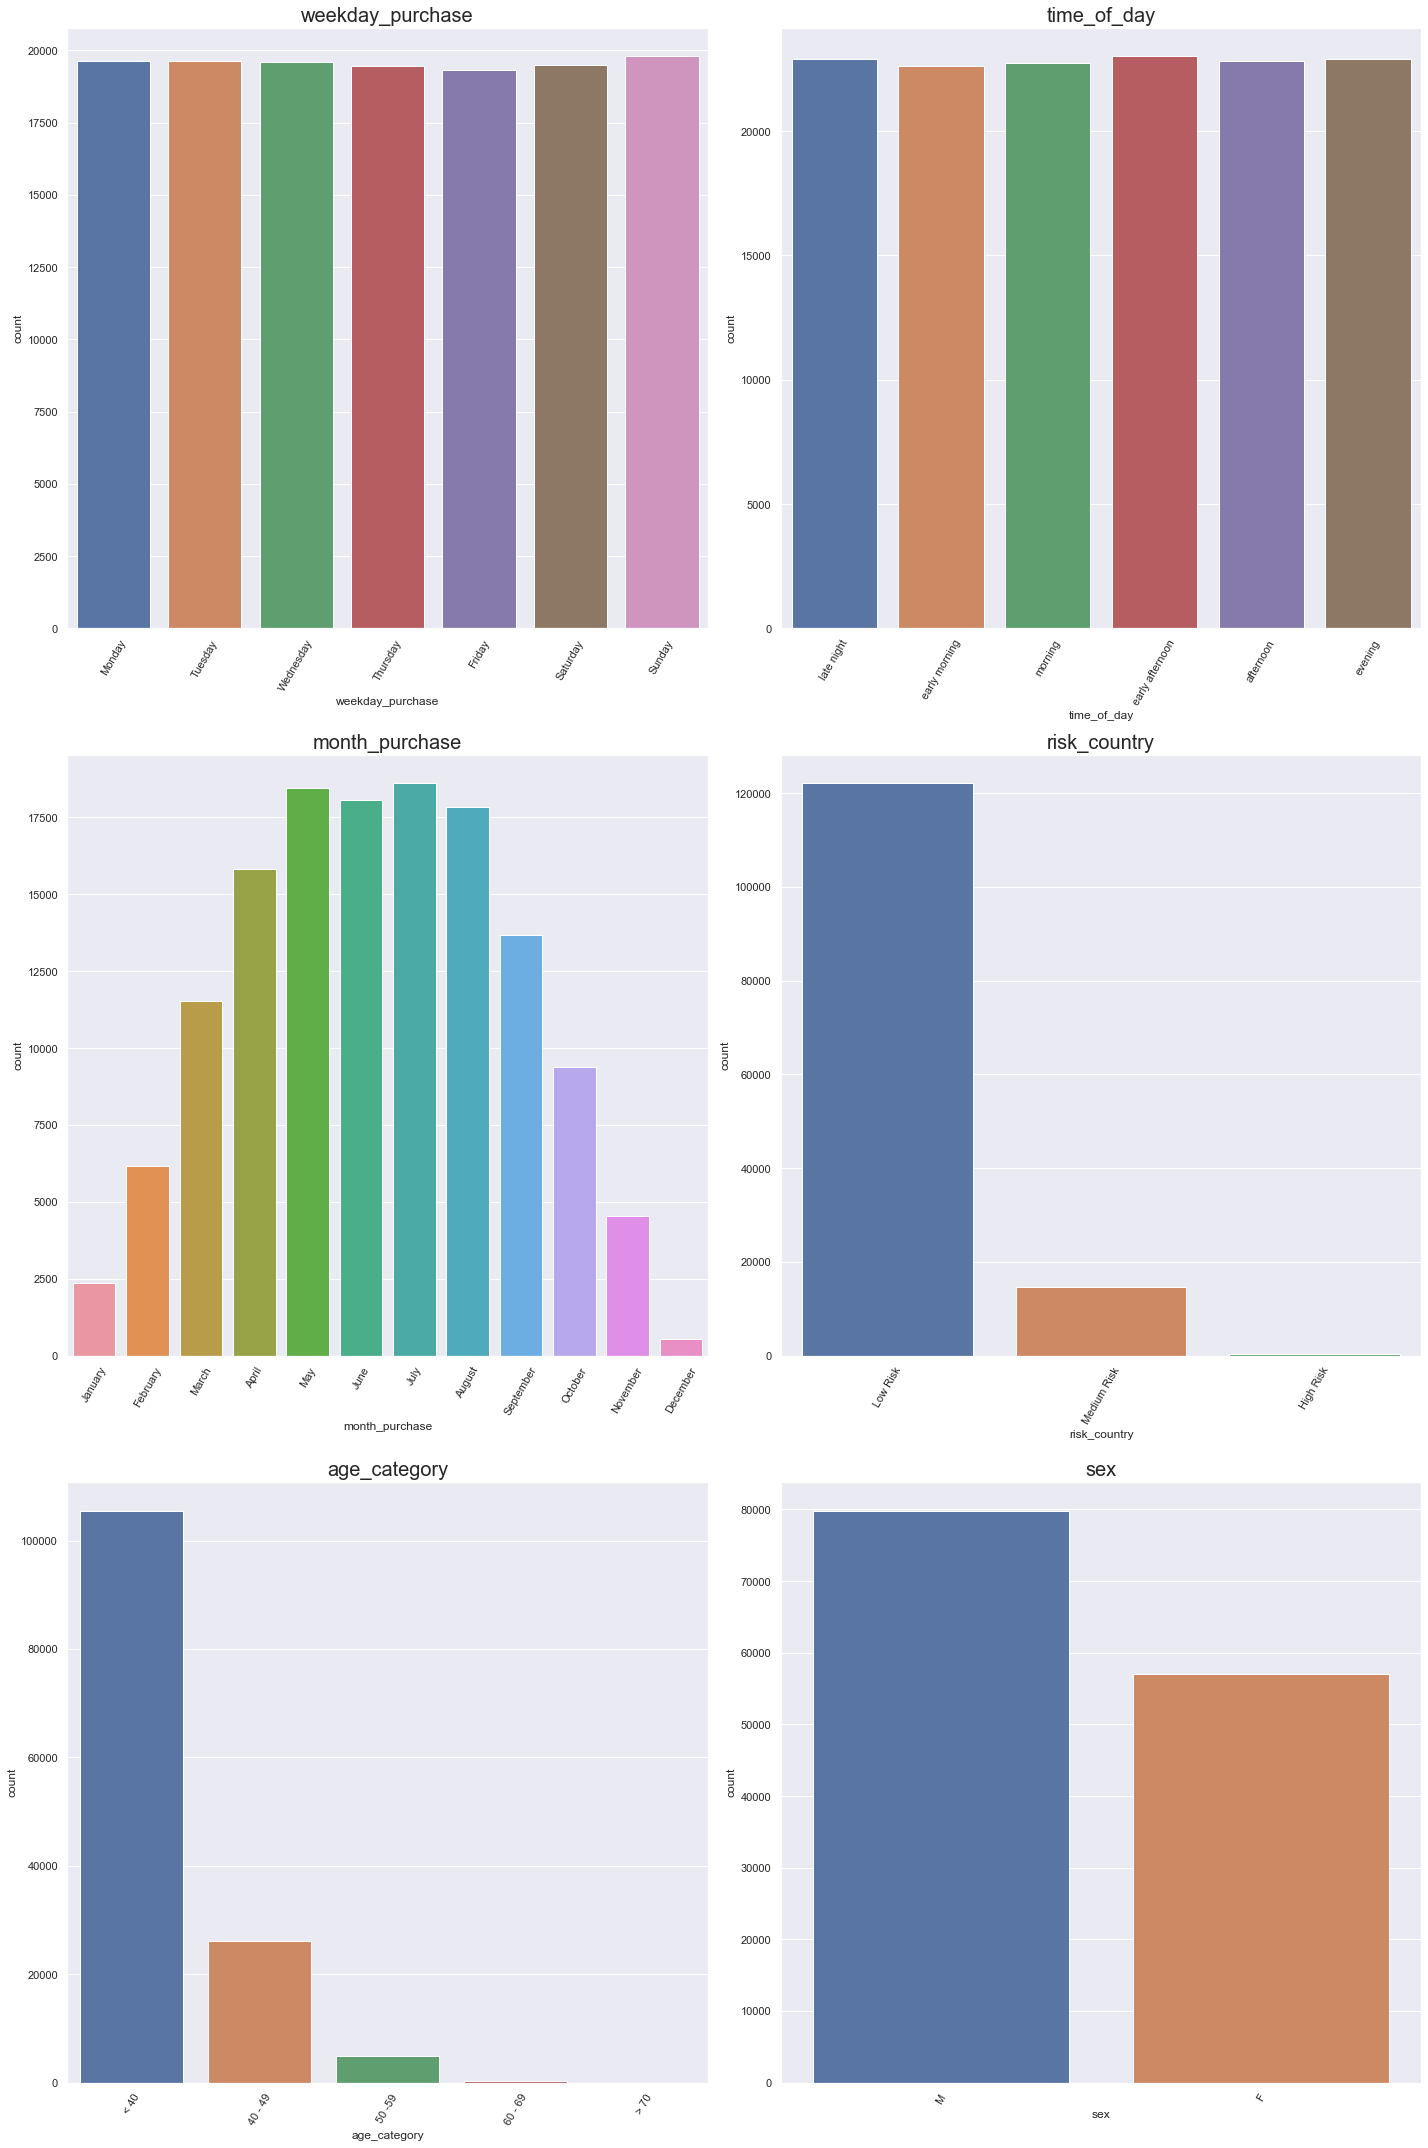

In [15]:
# Set up the matplotlib figure for non fraud data
f, axes = plt.subplots(3, 2, figsize=(20, 30), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=non_f_data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), r

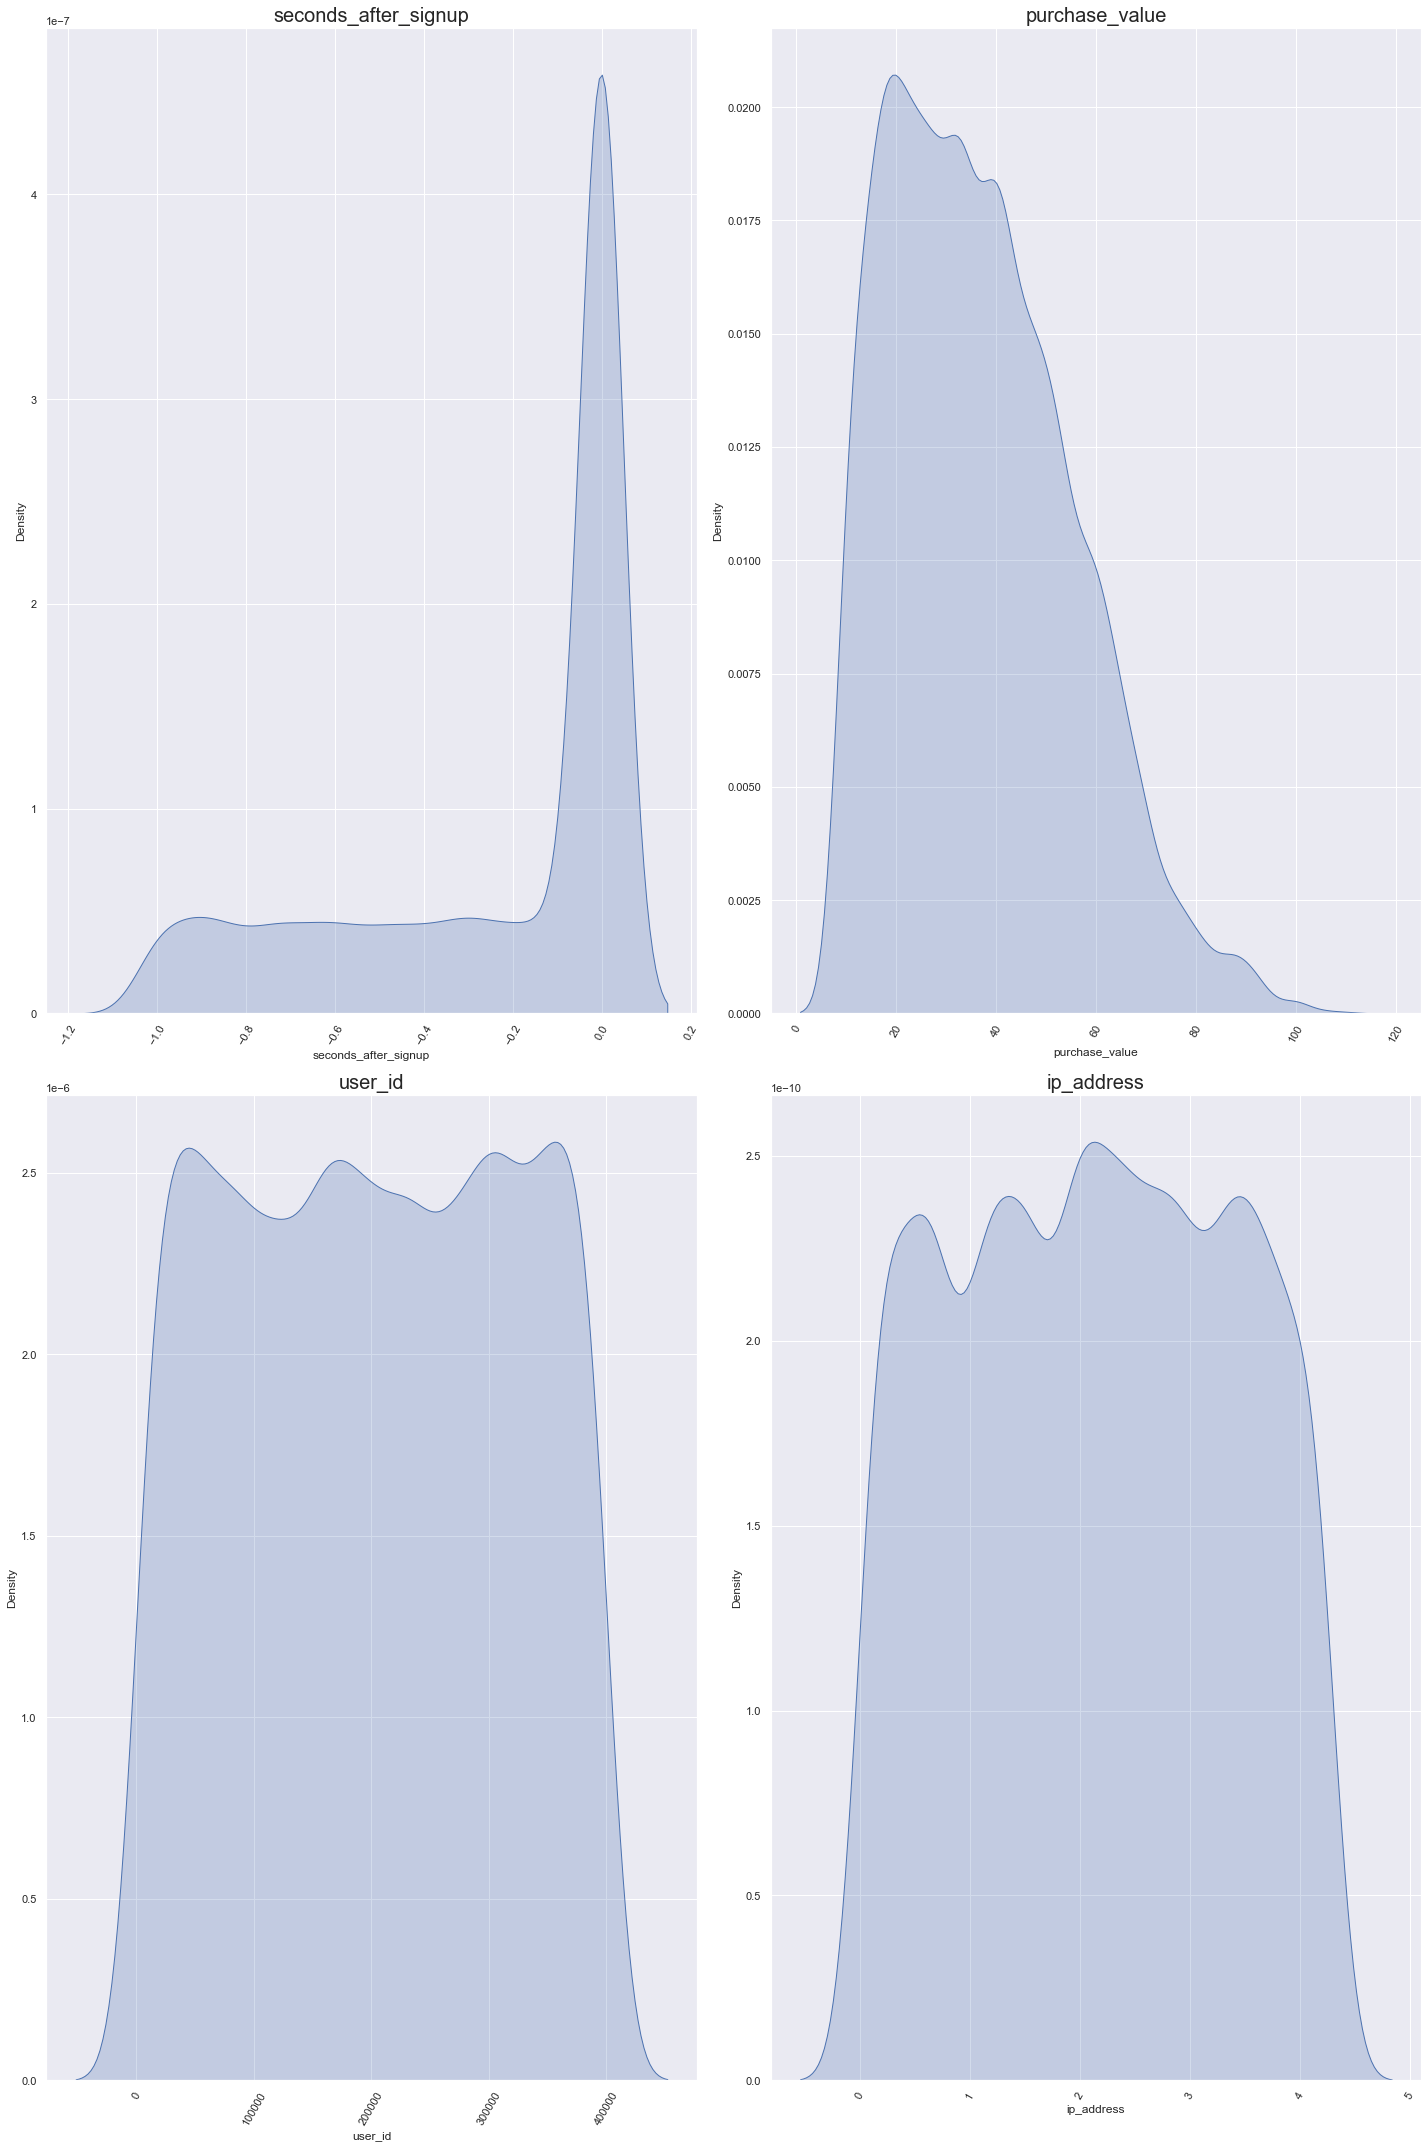

In [16]:
numerical_variables = ['seconds_after_signup', 'purchase_value', 'user_id', 'ip_address']

# Set up the matplotlib figure for fraud data
f, axes = plt.subplots(2, 2, figsize=(20, 30), sharex=False)

# sns.despine(left=True)
for index, name in enumerate(numerical_variables):
    sns.kdeplot(f_data[name], fill=True, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotat

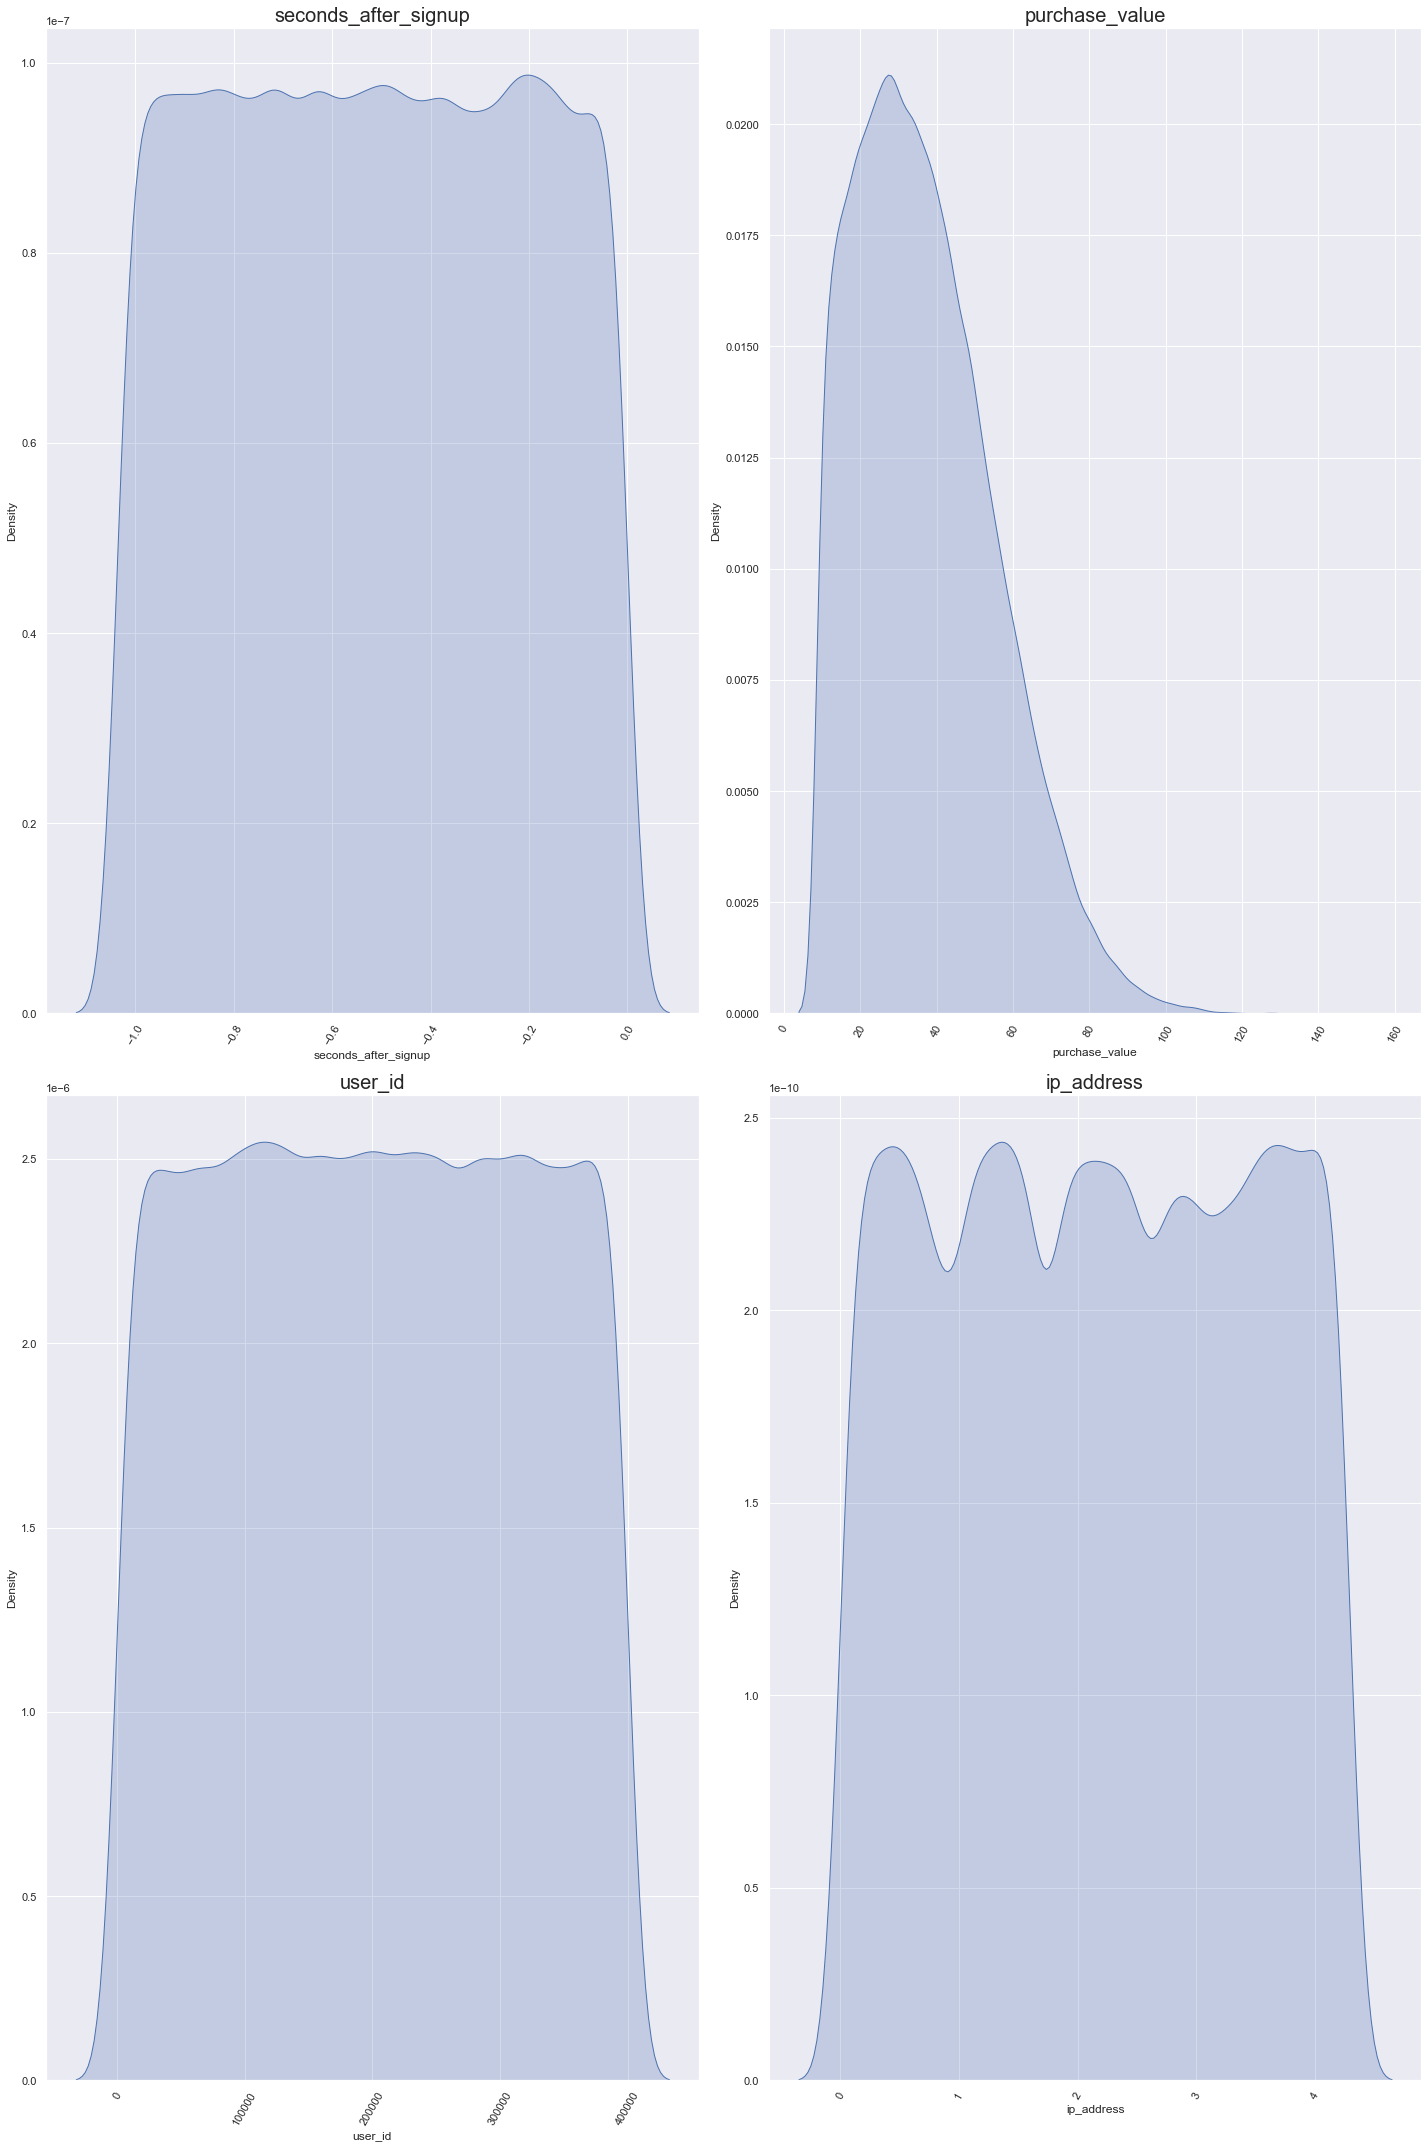

In [17]:
# Set up the matplotlib figure for non fraud data
f, axes = plt.subplots(2, 2, figsize=(20, 30), sharex=False)

# sns.despine(left=True)
for index, name in enumerate(numerical_variables):
    sns.kdeplot(non_f_data[name], fill=True, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

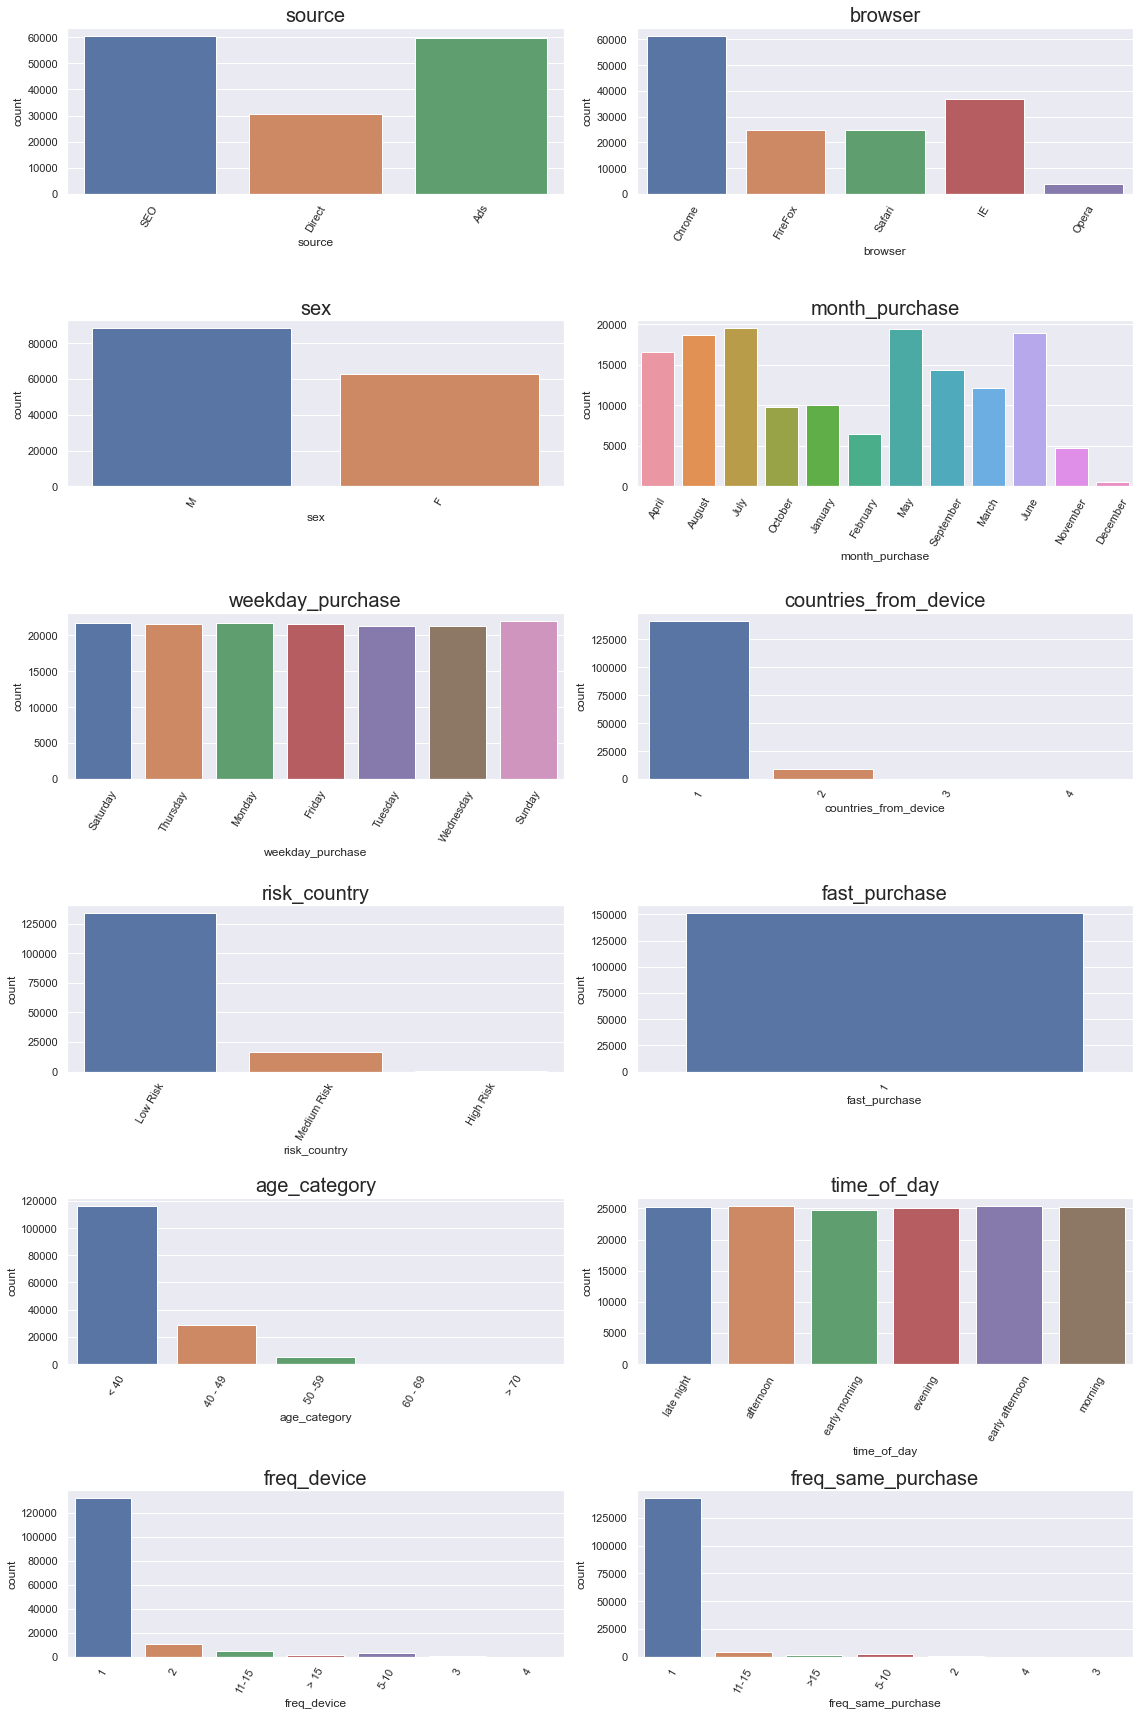

In [18]:
cat_variables = dataset[['source', 'browser', 'sex',
 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'fast_purchase', 'age_category', 'time_of_day', 'freq_device', 'freq_same_purchase']]

f, axes = plt.subplots(6, 2, figsize=(16, 24), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=dataset, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/3924221380.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[index] = plt.subplot(3, 2, index+1, label=str(index))


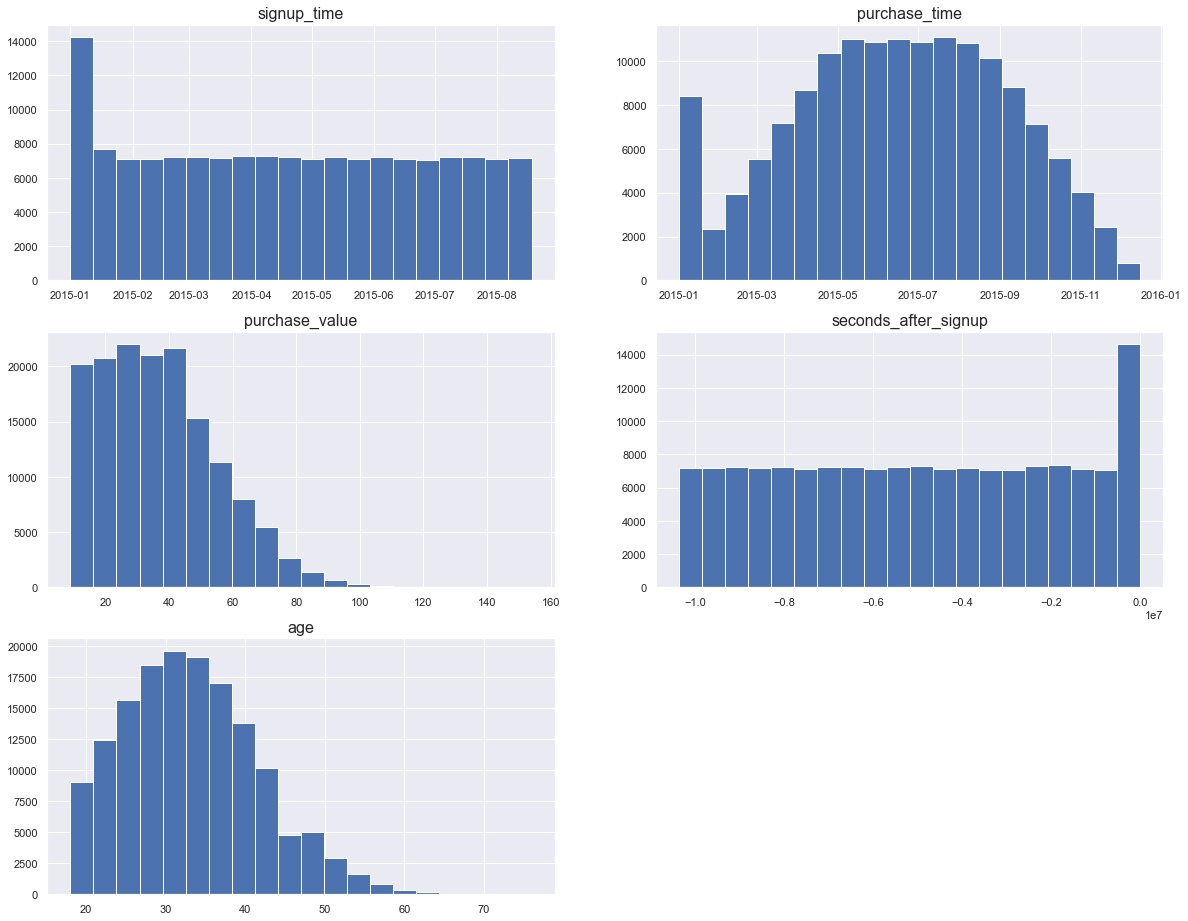

In [19]:
numerical_variables = ['signup_time', 'purchase_time', 'purchase_value', 'seconds_after_signup', 'age']
plt.figure(figsize=(20,16))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(dataset[numerical_variables].columns):
    axes[index] = plt.subplot(3, 2, index+1, label=str(index))
    dataset[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

## Check for correlation between risk_country v all countries

remove all countries since they are correlated with risk_country. Verified with chi2 contingency

In [20]:
datasetCR = dataset[['IP_country', 'risk_country']].groupby(['IP_country', 'risk_country']).size()
datasetCR

IP_country             risk_country
Afghanistan            Medium Risk       6
Albania                Low Risk         13
Algeria                Medium Risk     122
Angola                 Low Risk         24
Antigua and Barbuda    Low Risk          3
                                      ... 
Viet Nam               Low Risk        550
Virgin Islands (U.S.)  High Risk         3
Yemen                  Low Risk          1
Zambia                 Low Risk         10
Zimbabwe               Low Risk          6
Length: 182, dtype: int64

In [21]:
datasetCR = datasetCR.unstack().fillna(0)
datasetCR = datasetCR.transpose() 
datasetCR

IP_country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire; Sint Eustatius; Saba,Bosnia and Herzegowina,Botswana,Brazil,British Indian Ocean Territory,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Chile,China,Colombia,Congo,Congo The Democratic Republic of The,Costa Rica,Cote D'ivoire,Croatia (LOCAL Name: Hrvatska),Cuba,Curacao,Cyprus,Czech Republic,Denmark,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,European Union,Faroe Islands,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Gibraltar,Greece,Guadeloupe,Guam,Guatemala,Haiti,Honduras,Hong Kong,Hungary,Iceland,India,Indonesia,Iran (ISLAMIC Republic Of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Korea Republic of,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Lesotho,Libyan Arab Jamahiriya,Liechtenstein,Lithuania,Luxembourg,Macau,Macedonia,Madagascar,Malawi,Malaysia,Maldives,Malta,Mauritius,Mexico,Moldova Republic of,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Norway,Oman,Pakistan,Palestinian Territory Occupied,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russian Federation,Rwanda,Saint Kitts and Nevis,Saint Martin,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia (SLOVAK Republic),Slovenia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Sweden,Switzerland,Syrian Arab Republic,Taiwan; Republic of China (ROC),Tajikistan,Tanzania United Republic of,Thailand,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
risk_country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
High Risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Low Risk,0.0,13.0,0.0,24.0,3.0,661.0,0.0,1844.0,435.0,23.0,4.0,14.0,37.0,9.0,72.0,0.0,7.0,2.0,2.0,2.0,0.0,1.0,30.0,3.0,2961.0,1.0,7.0,166.0,2.0,1.0,15.0,5.0,0.0,1.0,4.0,0.0,12038.0,602.0,3.0,3.0,0.0,0.0,79.0,9.0,3.0,43.0,349.0,0.0,3.0,1.0,51.0,0.0,0.0,25.0,42.0,4.0,238.0,3.0,2.0,460.0,3161.0,9.0,1.0,32.0,3646.0,11.0,2.0,0.0,1.0,7.0,20.0,4.0,0.0,0.0,211.0,0.0,0.0,649.0,0.0,20.0,0.0,272.0,1944.0,7.0,7306.0,28.0,92.0,93.0,4162.0,0.0,18.0,4.0,64.0,0.0,2.0,14.0,2.0,0.0,0.0,10.0,24.0,1.0,0.0,210.0,2.0,0.0,17.0,0.0,37.0,3.0,6.0,0.0,158.0,16.0,1.0,0.0,1.0,18.0,1680.0,5.0,0.0,16.0,1.0,67.0,0.0,41.0,186.0,16.0,62.0,4.0,35.0,0.0,177.0,729.0,229.0,30.0,25.0,3.0,525.0,1616.0,15.0,2.0,1.0,1.0,0.0,0.0,69.0,0.0,208.0,86.0,87.0,838.0,1.0,1027.0,0.0,25.0,0.0,785.0,24.0,1237.0,1.0,15.0,291.0,22.0,0.0,568.0,0.0,13.0,0.0,0.0,0.0,58049.0,21966.0,80.0,0.0,1.0,0.0,550.0,0.0,1.0,10.0,6.0
Medium Risk,6.0,0.0,122.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,409.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2975.0,0.0,0.0,417.0,0.0,0.0,0.0,0.0,90.0,6.0,0.0,

<AxesSubplot: xlabel='IP_country', ylabel='risk_country'>

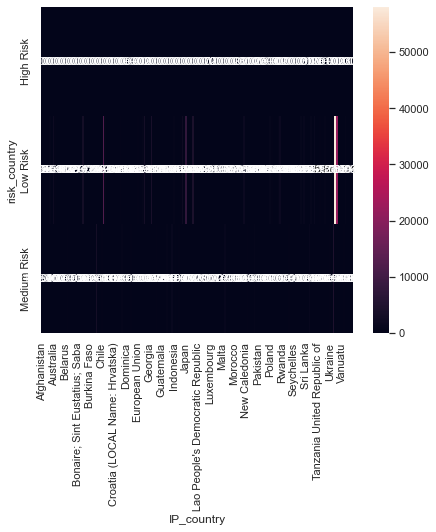

In [22]:
sns.heatmap(datasetCR, annot=True)

In [23]:
dataset.risk_country.unique()

array(['Low Risk', 'Medium Risk', 'High Risk'], dtype=object)

In [24]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(datasetCR) 
# Print the p-value
print("p value\t\t\t", p)

print("Chi2 Contingency\t", c)

p value			 0.0
Chi2 Contingency	 302224.00000000006


## Check for correlated variables with various numerical variables as dependent variable

In [25]:
model = ols('purchase_value ~ age_category + ip_address + seconds_after_signup + hour_of_the_day + month_purchase + weekday_purchase + risk_country + time_of_day + sex + fast_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.860848e+03,465.211876,1.385878,0.235937
month_purchase,11.0,5.592780e+03,508.434589,1.514640,0.118323
weekday_purchase,6.0,3.353721e+03,558.953496,1.665137,0.125047
risk_country,2.0,6.205795e+02,310.289751,0.924361,0.396787
time_of_day,5.0,5.613611e+03,1122.722211,3.344619,0.005058
sex,1.0,1.944080e+02,194.408030,0.579147,0.446648
fast_purchase,0.0,0.000000e+00,NaN,NaN,NaN
ip_address,1.0,1.529120e+00,1.529120,0.004555,0.946189
seconds_after_signup,1.0,1.983638e+01,19.836382,0.059093,0.807935
hour_of_the_day,1.0,4.783576e+01,47.835758,0.142504,0.705805


In [26]:
model = ols('seconds_after_signup ~ age_category + ip_address + purchase_value + hour_of_the_day + month_purchase + weekday_purchase + risk_country + time_of_day + sex + fast_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.612254e+13,4.030634e+12,0.635580,0.637075
month_purchase,11.0,5.186753e+17,4.715230e+16,7435.321064,0.000000
weekday_purchase,6.0,3.827906e+13,6.379844e+12,1.006021,0.419160
risk_country,2.0,1.139306e+13,5.696530e+12,0.898271,0.407275
time_of_day,5.0,3.244280e+13,6.488559e+12,1.023164,0.401914
sex,1.0,1.019222e+13,1.019222e+13,1.607185,0.204890
fast_purchase,0.0,0.000000e+00,NaN,NaN,NaN
ip_address,1.0,3.545728e+12,3.545728e+12,0.559116,0.454618
purchase_value,1.0,3.747508e+11,3.747508e+11,0.059093,0.807935
hour_of_the_day,1.0,6.932817e+12,6.932817e+12,1.093218,0.295761


## Feature Selection

### XGBoost


In [27]:
cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex',
 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'fast_purchase', 'age_category', 'time_of_day', 'freq_device', 'freq_same_purchase']])

numerical_variables = dataset[['purchase_value', 'seconds_after_signup', 'age']]


dataset_2 = pd.concat([cat_encoded, numerical_variables], axis = 1)

In [ ]:
# cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex', 'month_purchase', 'weekday_purchase',
#         'countries_from_device',
#        'risk_country', 'quick_purchase', 'age_category', 'period_of_the_day', 'freq_same_purchase']])
# numerical = dataset[['purchase_value', 'seconds_since_signup']] # Removed age

# dataset = pd.concat([cat_encoded, numerical], axis = 1)

#dont delete first

In [28]:
X = dataset_2
y = dataset[['class']]

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [30]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [31]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of

[11:39:43] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

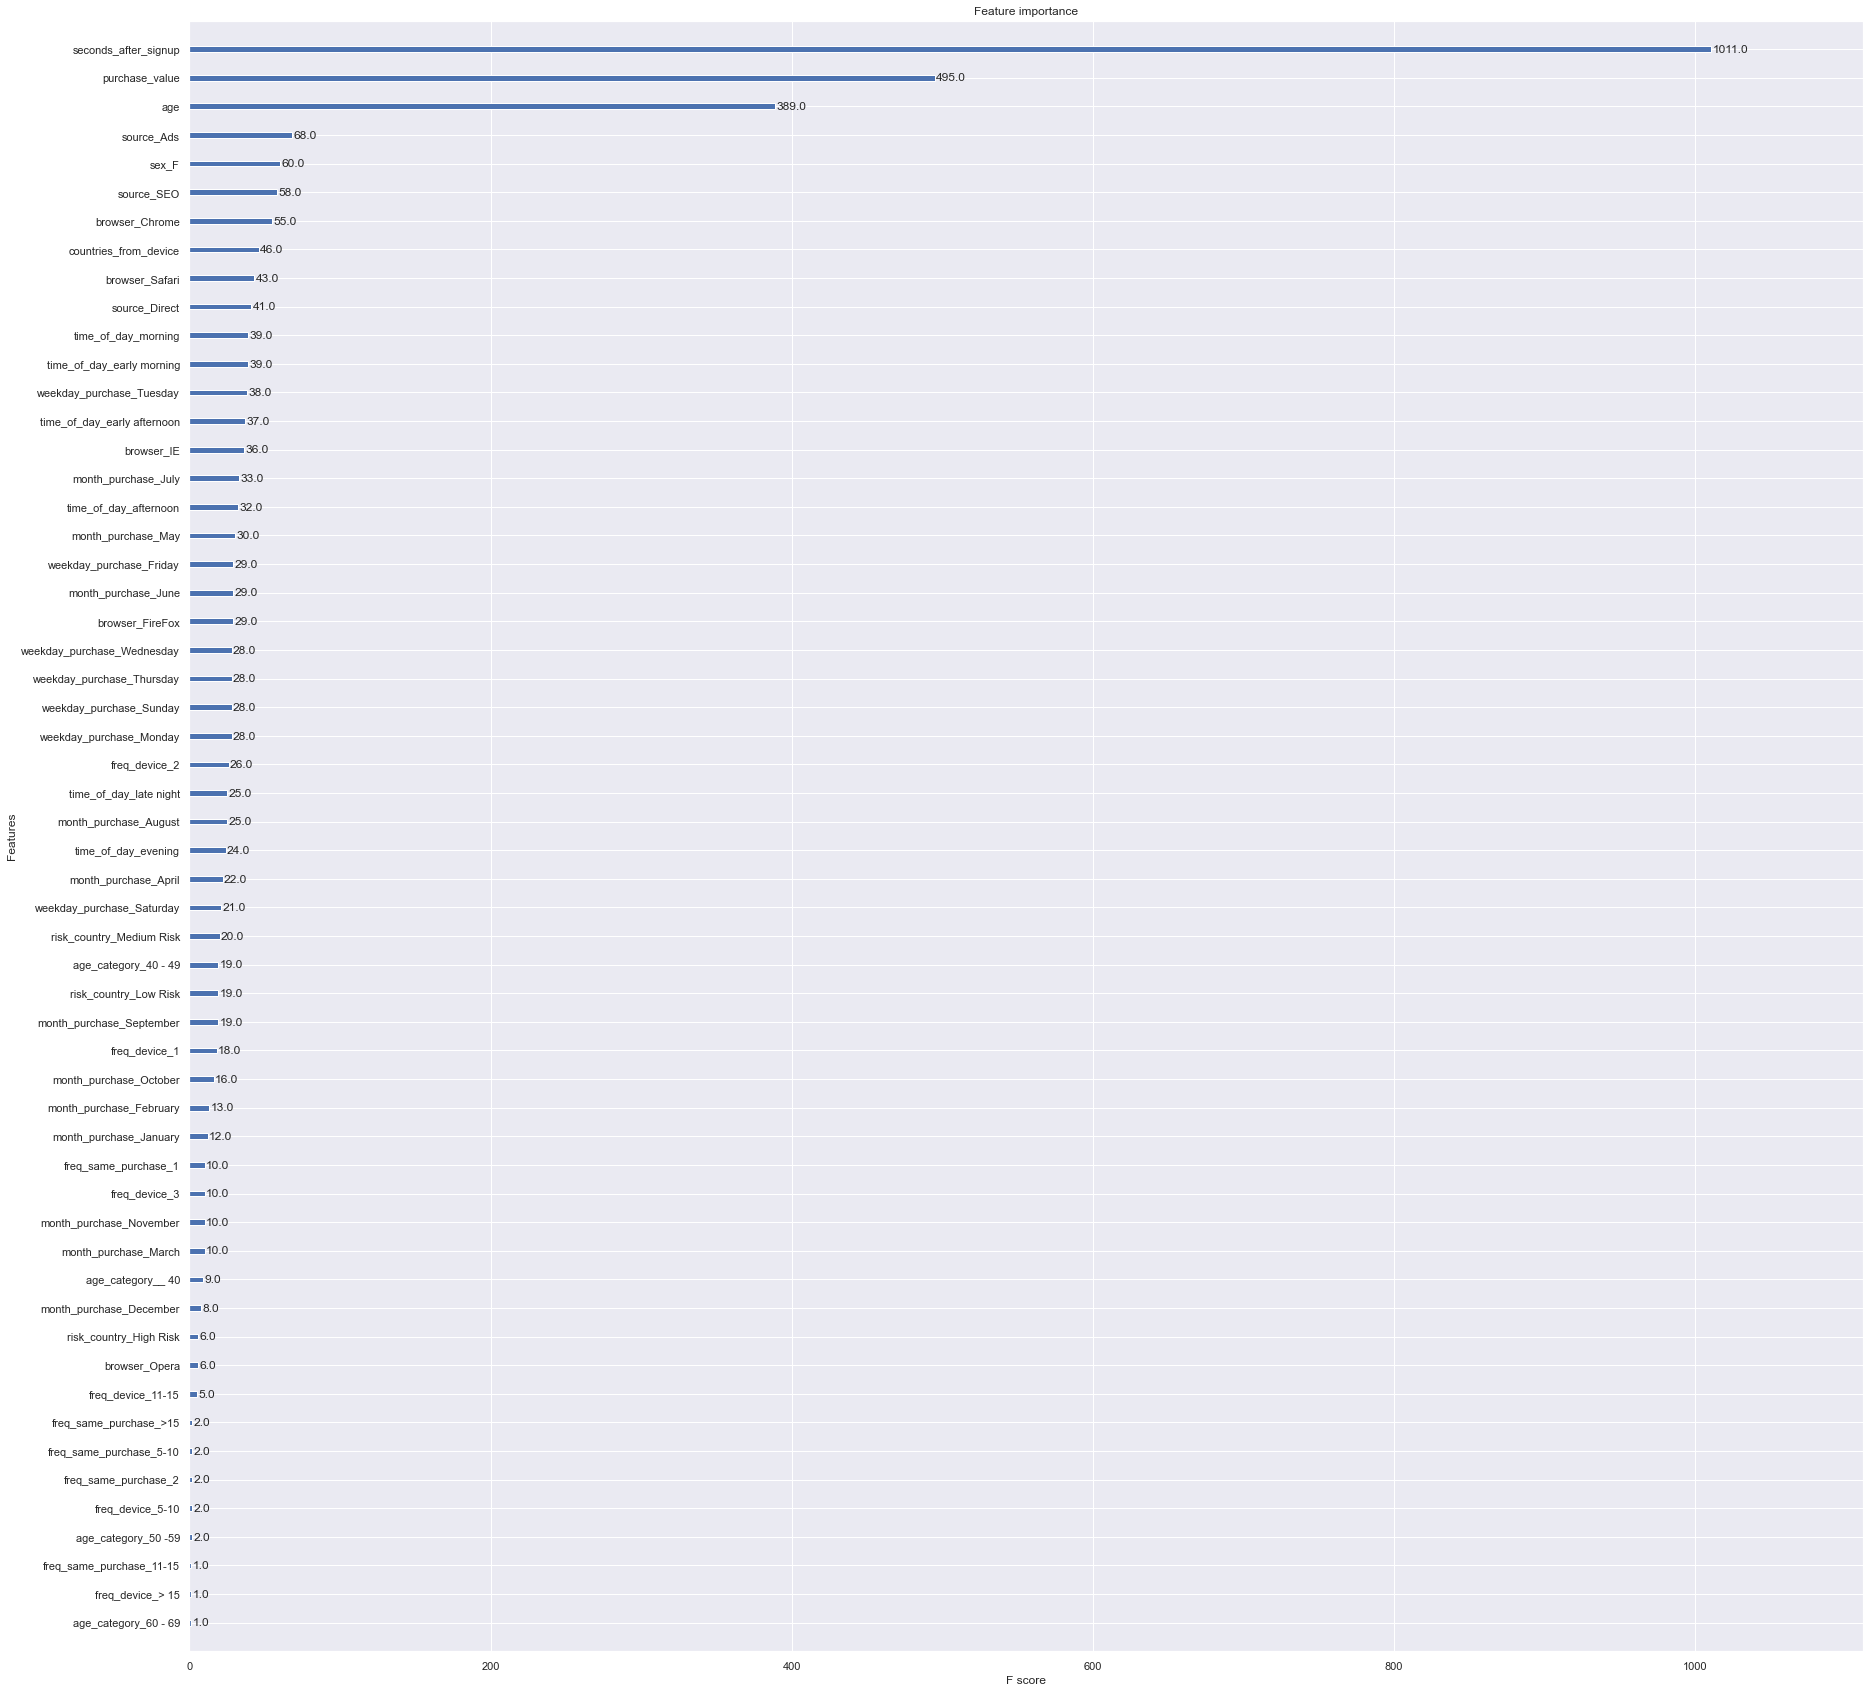

In [32]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))

### Recursive Feature Elimination (RFE)

In [33]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_


array([22,  8,  1, 26,  1,  1,  1, 24,  7,  1, 16, 17, 14, 34, 21, 33, 10,
        1, 19,  5, 29, 20, 11, 18,  2,  1, 15,  1,  4, 13, 36, 31, 27, 46,
       47, 28, 32, 43, 25, 23,  1, 12,  9,  6,  3, 42, 44,  1, 37, 48, 41,
       45, 30, 35, 49, 40, 39, 38, 50,  1,  1,  1])

In [34]:
ranking = pd.DataFrame([ 1, 41, 18, 19, 23,  1,  5,  1, 26,  1, 15,  1,  8, 25, 36, 22, 29,
        4,  1, 16,  9, 27, 17, 11,  1, 20,  2, 10, 14,  1,  7, 32, 38, 35,
       37, 44, 21, 28, 39, 24,  1, 12, 13,  3,  1,  6, 30, 31, 43, 40, 33,
       34, 42,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'month_purchase_April',
       'month_purchase_August', 'month_purchase_December',
       'month_purchase_February', 'month_purchase_January',
       'month_purchase_July', 'month_purchase_June', 'month_purchase_March',
       'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High Risk',
       'risk_country_Low Risk', 'risk_country_Medium Risk', 'fast_purchase_0',
       'fast_purchase_1', 'age_category_ > 70', 'age_category_40 - 49',
       'age_category_50 -59', 'age_category_60 - 69', 'age_category__ 40',
       'time_of_day_afternoon', 'time_of_day_early afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of_day_late night', 'time_of_day_morning', 'freq_device_1',
       'freq_device_11-15', 'freq_device_2', 'freq_device_3',
       'freq_device_4', 'freq_device_5-10', 'freq_device_> 15',
       'freq_same_purchase_1', 'freq_same_purchase_2',
       'freq_same_purchase_3', 'freq_same_purchase_4',
       'freq_same_purchase_11-15', 'freq_same_purchase_5-10',
       'freq_same_purchase_>15', 'purchase_value', 'seconds', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [35]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [36]:
rslt_df

,ranking,features
0,1.0,countries_from_device
5,1.0,browser_FireFox
7,1.0,browser_Opera
9,1.0,sex_F
11,1.0,month_purchase_April
18,1.0,month_purchase_March
24,1.0,weekday_purchase_Monday
29,1.0,weekday_purchase_Wednesday
40,1.0,time_of_day_afternoon
44,1.0,time_of_day_late night


## Reading Final DataFrames, i.e. those that were upsampled

## Select the relevant columns for building the model (TTS & Upsample)

Take from XGBoost section for Train Test Split, the codes now also have upsampled dataset

In [37]:
final_df_X = dataset_2[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_after_signup']]

In [38]:
final_df_y = dataset[['class']]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
   final_df_X, final_df_y, test_size=0.30, random_state=42)

In [40]:
train_df = pd.concat([X_train, y_train], axis=1)

In [41]:
from sklearn.utils import resample

not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

0    95888
1    95888
Name: class, dtype: int64

In [42]:
final_x_train = upsampled[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_after_signup']]

In [43]:
final_y_train = upsampled[['class']]

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
stand = scaler.fit(final_x_train)
x_scaled_train = stand.transform(final_x_train)
x_scaled_test = stand.transform(X_test)
print(pd.DataFrame(x_scaled_train).describe())
print(pd.DataFrame(x_scaled_test).describe())

                 0             1             2             3             4   \
count  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05   
mean  -1.954910e-14 -1.781347e-14  8.034803e-14  3.522002e-14  5.153845e-14   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -3.532025e-01 -8.037529e-01 -5.246675e-01 -8.024001e-01 -8.465360e-01   
25%   -3.532025e-01 -8.037529e-01 -5.246675e-01 -8.024001e-01 -8.465360e-01   
50%   -3.532025e-01 -8.037529e-01 -5.246675e-01 -8.024001e-01 -8.465360e-01   
75%   -3.532025e-01  1.244163e+00 -5.246675e-01  1.246261e+00  1.181285e+00   
max    8.884332e+00  1.244163e+00  1.905969e+00  1.246261e+00  1.181285e+00   

                 5             6             7             8             9   \
count  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05   
mean  -1.055278e-14 -1.086881e-14  5.330667e-15 -2.827234e-15  1.717113e-15   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.

## Logistic Regression

### Correlation Checking

In [46]:
cat_vars = [
    'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_Safari', 'sex_F', 'weekday_purchase_Thursday', 'age_category_ > 70', 
    'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69','age_category_< 40', 'time_of_day_afternoon',
    ]
    
num_vars = ['countries_from_device', 'purchase_value', 'seconds_after_signup']

features_selected = ['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_after_signup']

#### Chi Square Test (Categorical vs Catergorical)

In [47]:
p_values = []
chai_stats = []
for cat1 in cat_vars:
    for cat2 in cat_vars:
            crosstab = pd.crosstab(dataset_2[cat1], dataset_2[cat2])
            chai2, p_val, _, _ = chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))

chisquare = pd.DataFrame(p_values, columns=['Categorical 1', 'Categorical 2', 'p-value'])
chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value')

Categorical 2,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,browser_Chrome,browser_Safari,sex_F,source_Ads,source_Direct,source_SEO,time_of_day_afternoon,weekday_purchase_Thursday
Categorical 1,,,,,,,,,,,,,
age_category_ > 70,0.000000e+00,3.029295e-01,1.000000e+00,1.000000e+00,3.417567e-07,0.914181,1.000000,1.000000,0.963895,0.164399,0.450235,0.376163,0.454209
age_category_40 - 49,3.029295e-01,0.000000e+00,7.633076e-295,5.064812e-22,0.000000e+00,0.791410,0.815478,0.202494,0.095534,0.384235,0.017138,0.581859,0.308847
age_category_50 -59,1.000000e+00,7.633076e-295,0.000000e+00,1.648559e-04,0.000000e+00,0.274124,0.029245,0.638514,0.048215,1.000000,0.048077,0.316238,0.048300
age_category_60 - 69,1.000000e+00,5.064812e-22,1.648559e-04,0.000000e+00,1.275374e-293,0.408254,0.166818,0.936471,0.183552,1.000000,0.185871,0.741492,0.362758
age_category_< 40,3.417567e-07,0.000000e+00,0.000000e+00,1.275374e-293,0.000000e+00,0.391709,0.359618,0.156141,0.406629,0.399899,0.127329,0.895348,0.052721
browser_Chrome,9.141806e-01,7.914103e-01,2.741243e-01,4.082544e-01,3.917085e-01,0.000000,0.000000,0.835759,0.715044,0.000276,0.008988,0.437667,0.368526
browser_Safari,1.000000e+00,8.154776e-01,2.924522e-02,1.668185e-01,3.596182e-01,0.000000,0.000000,0.523753,0.719170,0.046143,0.045368,0.189722,0.023199
sex_F,1.000000e+00,2.024941e-01,6.385143e-01,9.364713e-01,1.561406e-01,0.835759,0.523753,0.000000,0.938092,0.498873,0.523850,0.549670,0.951839
source_Ads,9.638946e-01,9.553412e-02,4.821504e-02,1.835520e-01,4.066292e-01,0.715044,0.719170,0.938092,0.000000,0.000000,0.000000,0.894604,0.411521


Text(0.5, 1.0, 'Chi-Square Correlation Heatmap (Cat vs Cat)')

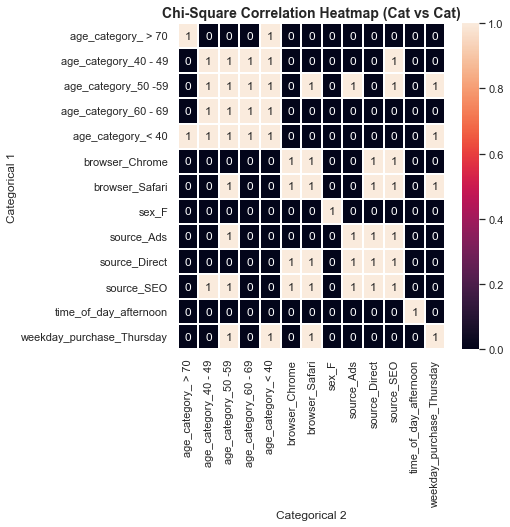

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.heatmap(round(chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value'),2) <= 0.05,
                 annot=True, 
                 linewidths=.05)

plt.title('Chi-Square Correlation Heatmap (Cat vs Cat)', fontsize=14, fontweight='bold')

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for chi square test, 1 indicating the rejection of null hypothesis, the categorical variables are correlated between one another.

#### Pearson Correlation (Numerical vs Numerical)

Text(0.5, 1.0, 'Pearson Correlation Heatmap (Num vs Num)')

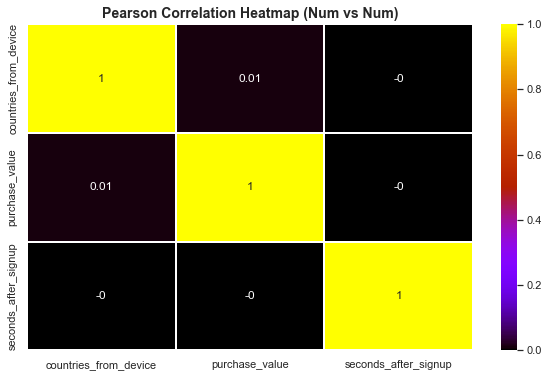

In [49]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
corrMatrix = dataset[num_vars].corr()
sns.heatmap(round(corrMatrix, 2), ax=ax,annot=True, cmap=cmap,linewidths=.05)

plt.title('Pearson Correlation Heatmap (Num vs Num)', fontsize=14, fontweight='bold')

From the correlation matrix, the numerical variables are not correlated to one another.

#### Anova Test (Numerical vs Categorical)

In [50]:
results = []

for cat in cat_vars:
    for num in num_vars:
        
        candidates = []
        for val in dataset_2[cat].unique():
            if len(dataset_2[dataset_2[cat]==val][num])>0:
                candidates.append(dataset_2[dataset_2[cat]==val][num])
                
        _, p_val = f_oneway(*candidates)
        results.append((cat, num, p_val))

In [51]:
anova = pd.DataFrame(results, columns=['Categorical', 'Numerical', 'P-value'])
anova.pivot_table(index='Numerical', columns='Categorical')

P-value                       \
Categorical           age_category_ > 70 age_category_40 - 49   
Numerical                                                       
countries_from_device           0.442735             0.549494   
purchase_value                  0.429586             0.031523   
seconds_after_signup            0.842212             0.556712   

                                                                \
Categorical           age_category_50 -59 age_category_60 - 69   
Numerical                                                        
countries_from_device            0.089754             0.936362   
purchase_value                   0.743723             0.826648   
seconds_after_signup             0.282725             0.639719   

                                                                       \
Categorical           age_category_< 40 browser_Chrome browser_Safari   
Numerical                                                               
countries_from_device          0.824131       0.844776       0.912697   
purchase_value                 0.034699       0.090500       0.427408   
seconds_after_signup           0.993261       0.000002       0.000319   

                                                                     \
Categorical               sex_F source_Ads source_Direct source_SEO   
Numerical                                                             
countries_from_device  0.551148   0.053254      0.281114   0.296028   
purchase_value         0.437897   0.864608      0.956089   0.900518   
seconds_after_signup   0.042767   0.276691      0.553557   0.116090   

                                                                       
Categorical           time_of_day_afternoon weekday_purchase_Thursday  
Numerical                                                              
countries_from_device              0.452470                  0.219103  
purchase_value                     0.581404                  0.032799  
seconds_after_signup               0.012348                  0.090526

Text(0.5, 1.0, 'Anova Test Correlation Heatmap (Num vs Cat)')

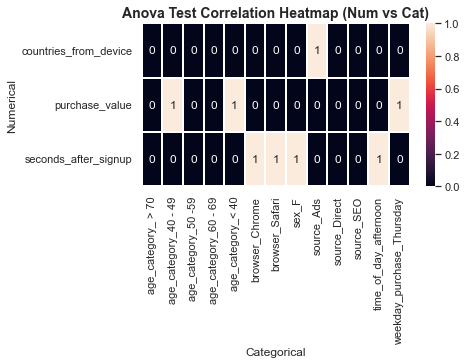

In [52]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

sns.heatmap(round(anova.pivot_table(index='Numerical', columns='Categorical', values='P-value'),2) <= 0.05,
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 annot=True, 
                 linewidths=.05)

plt.title('Anova Test Correlation Heatmap (Num vs Cat)', fontsize=14, fontweight='bold')

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for anova test, 1 indicating the rejection of null hypothesis, all the numerical variables are correlated with some of the categorical variables.

`In conclusion, we noticed correlation between the features that we have selected, which we will take account of in the further stages.`

### Running of Logistic Regression Model
#### Tuning Hyperparameter (Penalty [Regularisation], C value [Regularisation Rate]) through Cross-Validation
##### Penalty

In [54]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l1', 'l2']
# define grid search
grid = dict(solver=solvers,penalty=penalty)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(x_scaled_train, final_y_train['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in sorted(zip(means, stds, params), reverse=True):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.795781 using {'penalty': 'l1', 'solver': 'saga'}
0.795781 with: {'penalty': 'l1', 'solver': 'saga'}
0.795775 with: {'penalty': 'l2', 'solver': 'saga'}


##### C value

In [55]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(x_scaled_train, final_y_train['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in sorted(zip(means, stds, params), reverse=True):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.795776 using {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.795776 with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.795776 with: {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}
0.795775 with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.795775 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.795773 with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.795744 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
0.795478 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


#### Actual Running of Model

In [56]:
# define models and parameters
model = LogisticRegression(solver='saga', penalty='l2', C=100)

# fit model
model.fit(x_scaled_train, final_y_train['class'])

# predict model
y_pred = model.predict(x_scaled_test)

# using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))

print('Train R2:', r2(final_y_train, model.predict(x_scaled_train)))
print('Test R2:', r2(y_test, model.predict(x_scaled_test)))

ACCURACY OF THE MODEL:  0.6857766797547095
precision score OF THE MODEL:  0.19822270583968082
recall score OF THE MODEL:  0.769537667214269
f1 score OF THE MODEL:  0.3152429937989713
ROC AUC score OF THE MODEL:  0.7233124023749381
Train R2: -0.12103704321708664
Test R2: -2.689933458468714


## Random Forest Classifer 
### Before Upsampling

In [57]:
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rfc.fit(X_train, y_train)

rfc.decision_path(X_train)

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/1880976047.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


(<105778x1440992 sparse matrix of type '<class 'numpy.int64'>'
 	with 207828806 stored elements in Compressed Sparse Row format>,
 array([      0,   14301,   28352,   42345,   56200,   71413,   85814,
         100271,  114804,  128995,  143374,  158177,  172270,  186441,
         200874,  215587,  230110,  243887,  258096,  272313,  286484,
         300817,  315082,  329125,  343782,  358071,  373426,  387253,
         401818,  416757,  430898,  445401,  460290,  474681,  488778,
         503299,  517264,  532669,  546524,  561481,  575528,  589839,
         604062,  618607,  633570,  647653,  662240,  676465,  690984,
         705427,  720072,  734389,  748770,  763073,  777774,  792693,
         806634,  820717,  834596,  849619,  864594,  879055,  893006,
         907939,  922306,  936027,  949878,  964669,  979072,  992815,
        1007264, 1021783, 1036488, 1051531, 1066220, 1080375, 1095584,
        1109513, 1123634, 1138181, 1152646, 1166875, 1181340, 1195255,
        1209874, 1

In [58]:
# Check training score
rfc.score(X_train, y_train)

0.9998771010985271

In [59]:
y_pred = rfc.predict(X_test)

# using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))

print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9495742709666034
precision score OF THE MODEL:  0.8594830724426648
recall score OF THE MODEL:  0.5540952827974653
f1 score OF THE MODEL:  0.6738013698630138
ROC AUC score OF THE MODEL:  0.7723486907498879
Confusion Matrix: 
[[40687   386]
 [ 1900  2361]]


In [60]:
# Try out other number of trees

n_trees = [50, 75, 200, 300]

for n in n_trees:
    print("=============== RFC standard data for {} Trees ==============".format(n))
    rfc = RandomForestClassifier(n_estimators = n, criterion="entropy")
    rfc.fit(X_train, y_train)
    
    print("Training score: ", rfc.score(X_train, y_train))
    
    y_pred = rfc.predict(X_test)
    print("Accuracy OF THE MODEL: ", accuracy_score(y_test, y_pred))
    print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
    print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
    print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
    print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))
    
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, y_pred))

=============== RFC standard data for 50 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/1502100100.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Training score:  0.9988182797935299
Accuracy OF THE MODEL:  0.9495080954691842
precision score OF THE MODEL:  0.858806404657933
recall score OF THE MODEL:  0.5538605961042009
f1 score OF THE MODEL:  0.67341988871451
ROC AUC score OF THE MODEL:  0.7722070005087022
Confusion Matrix: 
[[40685   388]
 [ 1901  2360]]
=============== RFC standard data for 75 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/1502100100.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Training score:  0.9997258409120989
Accuracy OF THE MODEL:  0.9498830899545595
precision score OF THE MODEL:  0.8641523251556207
recall score OF THE MODEL:  0.5538605961042009
f1 score OF THE MODEL:  0.6750572082379863
ROC AUC score OF THE MODEL:  0.7724139491124078
Confusion Matrix: 
[[40702   371]
 [ 1901  2360]]
=============== RFC standard data for 200 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/1502100100.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Training score:  1.0
Accuracy OF THE MODEL:  0.9497948559580006
precision score OF THE MODEL:  0.8626233101936427
recall score OF THE MODEL:  0.5540952827974653
f1 score OF THE MODEL:  0.6747642183480993
ROC AUC score OF THE MODEL:  0.7724704252226559
Confusion Matrix: 
[[40697   376]
 [ 1900  2361]]
=============== RFC standard data for 300 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/1502100100.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


Training score:  1.0
Accuracy OF THE MODEL:  0.9500374994485375
precision score OF THE MODEL:  0.866642174871418
recall score OF THE MODEL:  0.5536259094109364
f1 score OF THE MODEL:  0.6756408420449662
ROC AUC score OF THE MODEL:  0.7723939933439898
Confusion Matrix: 
[[40710   363]
 [ 1902  2359]]


## Random Forest Classifer 
### After Upsampling

In [61]:
rfc2 = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rfc2.fit(final_x_train, final_y_train)

rfc2.decision_path(final_x_train)

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2019752531.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc2.fit(final_x_train, final_y_train)


(<191776x2047390 sparse matrix of type '<class 'numpy.int64'>'
 	with 337001486 stored elements in Compressed Sparse Row format>,
 array([      0,   20761,   40660,   61039,   81100,  101981,  122144,
         142521,  163058,  183125,  203510,  223593,  243850,  264603,
         285022,  305883,  326750,  347707,  368214,  388817,  409492,
         429863,  450750,  471353,  491662,  511837,  532440,  552473,
         572578,  593087,  613116,  633699,  653994,  675393,  695594,
         715833,  736492,  757017,  777650,  798367,  818496,  839393,
         859660,  880385,  900908,  921141,  941754,  962263,  982686,
        1003063, 1023036, 1043577, 1063948, 1083885, 1104268, 1124409,
        1144906, 1166331, 1186584, 1207181, 1227784, 1248389, 1268036,
        1288903, 1309500, 1330221, 1350526, 1371061, 1391434, 1411635,
        1432306, 1453221, 1473506, 1494259, 1514882, 1534837, 1555522,
        1576209, 1596380, 1617517, 1637534, 1658955, 1678798, 1699331,
        1720194, 1

In [62]:
# Check training score
rfc2.score(X_train, y_train)

0.9999905462383483

In [63]:
y_pred = rfc2.predict(X_test)

# using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9346186085498742
precision score OF THE MODEL:  0.6786993662165886
recall score OF THE MODEL:  0.5780333255104435
f1 score OF THE MODEL:  0.6243346007604562
ROC AUC score OF THE MODEL:  0.7748224232304731


In [65]:
# Try out different number of trees
n_trees = [50, 75, 200, 300]

for n in n_trees:
   print("=============== RFC upsampled data for {} Trees ==============".format(n))
   rfc2 = RandomForestClassifier(n_estimators = n, criterion="entropy")
   rfc2.fit(final_x_train, final_y_train)
    
   print("Training score: ", rfc2.score(final_x_train, final_y_train))
    
   y_pred = rfc2.predict(X_test)
   print("Accuracy OF THE MODEL: ", accuracy_score(y_test, y_pred))
   print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
   print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
   print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
   print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))
    
   print("Confusion Matrix: ")
   print(confusion_matrix(y_test, y_pred))

=============== RFC upsampled data for 50 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2485355410.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc2.fit(final_x_train, final_y_train)


Training score:  0.9999843567495411
Accuracy OF THE MODEL:  0.9342436140644991
precision score OF THE MODEL:  0.6759208356239692
recall score OF THE MODEL:  0.5770945787373856
f1 score OF THE MODEL:  0.6226104570198759
ROC AUC score OF THE MODEL:  0.7741947950293457
Confusion Matrix: 
[[39894  1179]
 [ 1802  2459]]
=============== RFC upsampled data for 75 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2485355410.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc2.fit(final_x_train, final_y_train)


Training score:  0.9999895711663608
Accuracy OF THE MODEL:  0.933074513610094
precision score OF THE MODEL:  0.665587044534413
recall score OF THE MODEL:  0.578737385590237
f1 score OF THE MODEL:  0.6191313080592519
ROC AUC score OF THE MODEL:  0.7742857916191634
Confusion Matrix: 
[[39834  1239]
 [ 1795  2466]]
=============== RFC upsampled data for 200 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2485355410.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc2.fit(final_x_train, final_y_train)


Training score:  1.0
Accuracy OF THE MODEL:  0.933934795076543
precision score OF THE MODEL:  0.6731400437636762
recall score OF THE MODEL:  0.5775639521239145
f1 score OF THE MODEL:  0.6217001389415182
ROC AUC score OF THE MODEL:  0.7742347065661813
Confusion Matrix: 
[[39878  1195]
 [ 1800  2461]]
=============== RFC upsampled data for 300 Trees ==============


/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_1687/2485355410.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc2.fit(final_x_train, final_y_train)


Training score:  1.0
Accuracy OF THE MODEL:  0.9336480345877266
precision score OF THE MODEL:  0.6708481047177529
recall score OF THE MODEL:  0.5773292654306501
f1 score OF THE MODEL:  0.6205852674066599
ROC AUC score OF THE MODEL:  0.7739712818522275
Confusion Matrix: 
[[39866  1207]
 [ 1801  2460]]


## Neural Network

### Explore number of nodes in NN
### NN model 1 with 50 nodes

In [66]:
import keras
import tensorflow
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization, Dropout
# number of hidden nodes
H = 50
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1_1 = Sequential()

# layer 0
model1_1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
model1_1.add(BatchNormalization())

model1_1.add(Dropout(0.2))

# layer 1
model1_1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1_1.add(keras.layers.Dense(units=H, activation='relu')) 

model1_1.add(Dropout(0.2))

# layer 3
model1_1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1_1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1_1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1_1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1_1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1_1.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

2022-11-17 12:05:30.984592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 12:05:38.235699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
train_score = model1_1.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model1_1.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 0.4022168219089508
Test loss: 0.3946632146835327


In [68]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = (model1_1.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

1417/1417 [==============================] - 2s 1ms/step
True Positive(TP)  =  2959
False Positive(FP) =  3002
True Negative(TN)  =  38071
False Negative(FN) =  1302
accuracy: 0.9050602197026514
precision: 0.4963932226136554
recall: 0.6944379253696316
f1: 0.5789473684210527
roc: 0.8106742739598627


### NN model 2 with 100 nodes

In [69]:
# number of hidden nodes
H = 50
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1_2 = Sequential()

# layer 0
model1_2.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
model1_2.add(BatchNormalization())

model1_2.add(Dropout(0.2))

# layer 1
model1_2.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1_2.add(keras.layers.Dense(units=H, activation='relu')) 

model1_2.add(Dropout(0.2))

# layer 3
model1_2.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1_2.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1_2.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1_2.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1_2.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1_2.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [70]:
train_score = model1_2.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model1_2.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 0.4109410345554352
Test loss: 0.4014339745044708


In [71]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = (model1_2.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

1417/1417 [==============================] - 1s 928us/step
True Positive(TP)  =  2938
False Positive(FP) =  2594
True Negative(TN)  =  38479
False Negative(FN) =  1323
accuracy: 0.9135968588697225
precision: 0.5310918293564715
recall: 0.6895095048110772
f1: 0.6000204227509447
roc: 0.8131768301695197


### NN model 3 with 150 nodes

In [72]:
# number of hidden nodes
H = 50
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1_3 = Sequential()

# layer 0
model1_3.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
model1_3.add(BatchNormalization())

model1_3.add(Dropout(0.2))

# layer 1
model1_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1_3.add(keras.layers.Dense(units=H, activation='relu')) 

model1_3.add(Dropout(0.2))

# layer 3
model1_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1_3.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1_3.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1_3.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [73]:
train_score = model1_3.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model1_3.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 0.42305469512939453
Test loss: 0.4170718789100647


In [75]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = (model1_3.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

1417/1417 [==============================] - 1s 766us/step
True Positive(TP)  =  2936
False Positive(FP) =  2621
True Negative(TN)  =  38452
False Negative(FN) =  1325
accuracy: 0.9129571623946706
precision: 0.5283426309159619
recall: 0.6890401314245482
f1: 0.598085149724995
roc: 0.8126134603997818


### Explore optimization of NN with normalization and dropout
### NN Model 1 
- 100 nodes, 6 hidden layers, epoch = 100, batch size = 50, loss = 'binary_crossentropy', optimizer = 'adam'
- no normalization and no dropout

In [76]:
import keras
import tensorflow
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization, Dropout

# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1 = Sequential()

# layer 0
model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# layer 1
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 3
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [77]:
train_score = model1.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 0.24310515820980072
Test loss: 0.5609397292137146


In [78]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = (model1.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

1417/1417 [==============================] - 2s 1ms/step
True Positive(TP)  =  2681
False Positive(FP) =  3673
True Negative(TN)  =  37400
False Negative(FN) =  1580
accuracy: 0.8841267040190586
precision: 0.42193893610324207
recall: 0.6291950246421028
f1: 0.5051342439943477
roc: 0.7698844404733656


### NN Model 2 
- 100 nodes, 6 hidden layers, epoch = 100, batch size = 50, loss = 'binary_crossentropy', optimizer = 'adam'
- with normalization, 2x 0.2 dropout

In [79]:
# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model2_3 = Sequential()

# layer 0
model2_3.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
model2_3.add(BatchNormalization())

model2_3.add(Dropout(0.2))

# layer 1
model2_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model2_3.add(keras.layers.Dense(units=H, activation='relu')) 

model2_3.add(Dropout(0.2))

# layer 3
model2_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model2_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model2_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model2_3.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model2_3.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model2_3.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [80]:
train_score = model2_3.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model2_3.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 0.3860660195350647
Test loss: 0.38911598920822144


In [81]:
predictions = (model2_3.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

1417/1417 [==============================] - 1s 911us/step
True Positive(TP)  =  2928
False Positive(FP) =  3682
True Negative(TN)  =  37391
False Negative(FN) =  1333
accuracy: 0.8893766268143115
precision: 0.44296520423600605
recall: 0.6871626378784323
f1: 0.538680894121976
roc: 0.7987586860660392


### NN Model 3 
- 100 nodes, 6 hidden layers, epoch = 100, batch size = 50, loss = 'binary_crossentropy', optimizer = 'adam'
- normalization + 3x 0.3 dropout

In [82]:
# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model3_3 = Sequential()

# layer 0
model3_3.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

# batch normalization
model3_3.add(BatchNormalization())

model3_3.add(Dropout(0.3))

# layer 1
model3_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model3_3.add(keras.layers.Dense(units=H, activation='relu')) 

model3_3.add(Dropout(0.3))

# layer 3
model3_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model3_3.add(keras.layers.Dense(units=H, activation='relu')) 

model3_3.add(Dropout(0.3))

# layer 5
model3_3.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model3_3.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model3_3.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model3_3.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [83]:
train_score = model3_3.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model3_3.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 2.472095489501953
Test loss: 2.8770523071289062


In [84]:
predictions = (model3_3.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

1417/1417 [==============================] - 3s 894us/step
True Positive(TP)  =  2945
False Positive(FP) =  2717
True Negative(TN)  =  38356
False Negative(FN) =  1316
accuracy: 0.9110380729695151
precision: 0.5201342281879194
recall: 0.6911523116639287
f1: 0.5935704927945178
roc: 0.8125008995808992


### Evaluate the best optimiser for NN

In [85]:
def fit_model(optimizer):
    # number of hidden nodes
    H = 100
    # input dimension
    input_dim = 1
    # num of epochs
    num_epochs = 100

    # create sequential multi-layer perceptron
    model_optimiser = Sequential()

    # layer 0
    model_optimiser.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 
    # batch normalization
    model_optimiser.add(BatchNormalization())
    model_optimiser.add(Dropout(0.3))
    # layer 1
    model_optimiser.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 2
    model_optimiser.add(keras.layers.Dense(units=H, activation='relu')) 
    model_optimiser.add(Dropout(0.3))
    # layer 3
    model_optimiser.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 4
    model_optimiser.add(keras.layers.Dense(units=H, activation='relu')) 
    model_optimiser.add(Dropout(0.3))
    # layer 5
    model_optimiser.add(keras.layers.Dense(units=H, activation='relu')) 
    # layer 6 (output layer)
    model_optimiser.add(keras.layers.Dense(units=1, activation='sigmoid')) 
    # configure the model
    model_optimiser.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # fit the model 
    model_history1 = model_optimiser.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0, validation_data=(x_scaled_test, y_test))

    # plot learning curves
    plt.plot(model_history1.history['accuracy'], label='train')
    plt.plot(model_history1.history['val_accuracy'], label='test')
    plt.title('opt='+optimizer, pad=-80)

    # calculate loss score
    print(optimizer)
    train_score = model_optimiser.evaluate(x_scaled_train, final_y_train, verbose=0)
    print('Train loss:', train_score)
    test_score = model_optimiser.evaluate(x_scaled_test, y_test, verbose=0)
    print('Test loss:', test_score)

    # confusion matrix
    predictions = (model_optimiser.predict(x_scaled_test)>0.5).astype('int32')
    cm = confusion_matrix(y_test, predictions)

    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

    print('True Positive(TP)  = ', TP)
    print('False Positive(FP) = ', FP)
    print('True Negative(TN)  = ', TN)
    print('False Negative(FN) = ', FN)

    print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
    print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
    print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
    print("f1: " + "{f1}".format(f1 = metrics.f1_score(y_test,predictions)))
    print("roc: " + "{roc}".format(roc = metrics.roc_auc_score(y_test, predictions)))

sgd
Train loss: [0.43632972240448, 0.8144136667251587]
Test loss: [0.42628395557403564, 0.9125159978866577]
1417/1417 [==============================] - 2s 1ms/step
True Positive(TP)  =  2948
False Positive(FP) =  2653
True Negative(TN)  =  38420
False Negative(FN) =  1313
accuracy: 0.9125159924118763
precision: 0.5263345831101589
recall: 0.6918563717437222
f1: 0.5978503346177245
roc: 0.8136320302465111
rmsprop
Train loss: [0.7854139804840088, 0.5622861981391907]
Test loss: [0.4316551089286804, 0.8765165209770203]
1417/1417 [==============================] - 2s 1ms/step
True Positive(TP)  =  770
False Positive(FP) =  2107
True Negative(TN)  =  38966
False Negative(FN) =  3491
accuracy: 0.8765165218158556
precision: 0.26763990267639903
recall: 0.18070875381365878
f1: 0.21574670776127766
roc: 0.5647049234946121
adagrad
Train loss: [0.43530285358428955, 0.8114362359046936]
Test loss: [0.42595669627189636, 0.9122071862220764]
1417/1417 [==============================] - 1s 931us/step
True 

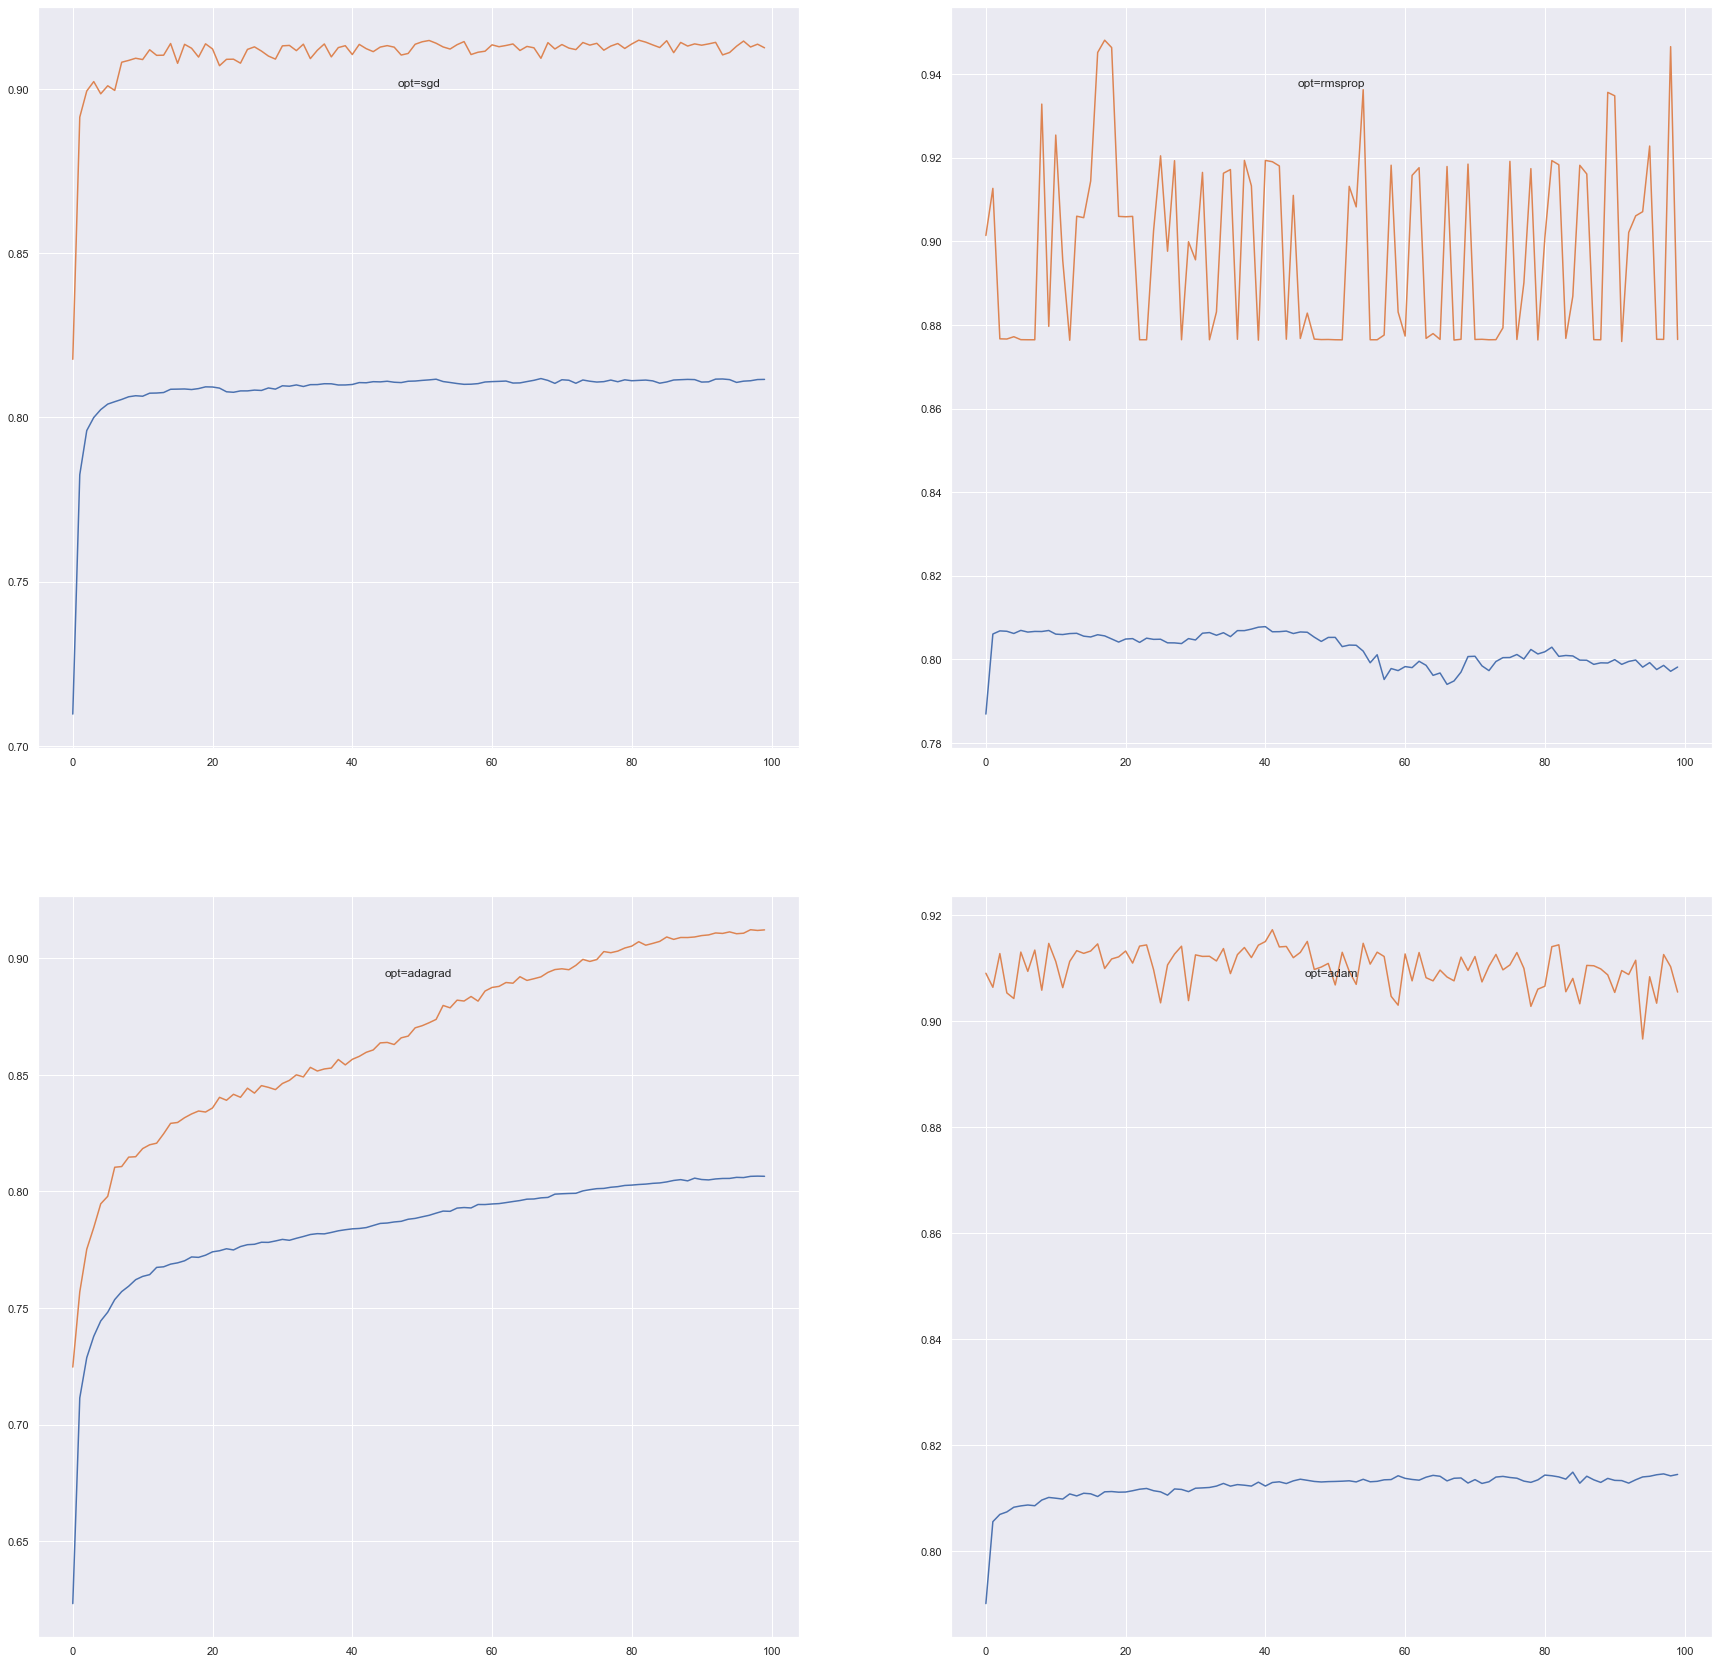

In [86]:
# create learning curves for different optimizers
momentums = ['sgd', 'rmsprop', 'adagrad', 'adam']
for i in range(len(momentums)):
	# determine the plot number
	plot_no = 220 + (i+1)
	plt.subplot(plot_no)
	# fit model and plot learning curves for an optimizer
	fit_model(momentums[i])
# show learning curves
plt.show()